In [1]:
t1 <- Sys.time()

# Purpose
The purpose of this study is to predict a HbA1c value given knowledge of the lagged HMA state, the twice-lagged HMA state, and however many lagged HbA1c values optimise the fit of the model.

# Considerations
For explainability, I restrict myself to regression and similar approaches. The observations of HbA1c and HMA state are repeated within patients, so the obvious first option is a Generalised Linear Mixed Model (GLMM).

GLMMs permit us to make use of the repeated observations. This wouldn't usually be permissible because repeated observations have a dependency between them (i.e. they are all from the same person), which violates an assumption of regression models fit using the ordinary-least squares procedure. A GLMM approach to our intended prediction model would, at the very least, include a random intercept for `person_id`, which would have the effect of nesting patients' repeated observations with a patient clustering variable. (I would refrain from including a random slope for repeat index because I have no sensible assumption about the form of the time-dependent trend in HbA1c.)

The problem with GLMMs, which makes them inappropriate for my task, is that the patient clustering variable that is used when fitting the model will be required for all future predictions. That is to say, GLMMs are resticted to making predictions about the patient records that informed the model, only. Such a model would be incapable of making predictions for other patient records, which is the intended use of the prediction model.

An alternative approach is to use Generalised Estimating Equations (GEEs). GEEs will provide the same coefficients as an equivalent GLMM, if there are no missing data, the same covariance structure is assumed, and an identity link function is used (note: the standard errors will be different, though). Crucially, the GEE handles the dependency between repeated observations differently to GLMMs such that a patient clustering variable is not required. This means that predictions can be made for never-before-observed patient records, so long as the 'predictors' are available for input. This is accomplished by encoding the dependency between repeated observations in the covariance matrix, rather than encoding it using an additional variable (i.e. the patient clustering variable used in the GLMM).

### Differences in interpretation.
GLMMs and GEEs are different approaches to summarising the sample data. Thus, the meaning of their coefficeints and predictions differ. The GEE provides a population-averaged prediction, conditional on the 'predictors'. In contrast, the GLMM would have provided a cluster-specific prediction, conditional on the 'predictors' and the value of the clustering variable. This is why the standard errors for the coefficients are different between the approaches.

### Why a GLMM will be helpful even though we won't use it.
Even though we can't use a GLMM for the ultimate prediction model, I will use a GLMM to choose which 'predictors' to include. The rationale is that GEEs are not models so they don't have any goodness-of-fit statistics to tell me when the data are good fit to the model. But I can calculate goodness-of-fit statistics from the equivalent GLMMs.

I will use Bayesian Information Criteria (BIC) on a GLMM to determine the best set of 'predictors' from my shortlist. I will then use a GEE with these 'predictors' to produce my prediction model.

## A note on missing data: a caveat for the preditions.
My intention is to used lagged values of the variate and the HMA-state variable as predictors. This means that the earlier observations in a patient's sequence will not have a value. For example, a patient's first observation cannot have a lagged observation because it is the first.

Unfortunately, I cannot include missing observations to inform the 'model' because they are meaningfully missing. The consequence is that the first few obsverations in every patient's record will be excluded. There are some patient records with only a few observations, so these patients' information with be excluded entirely.

Thus, the prediction model is only valid for patient records that have at least one more observation than the number of lags I include in the 'model'.

# Get requisite packages.

In [1]:
# Get requisite packages.
if( !"pacman" %in% installed.packages() )
{
  install.packages( "pacman" )
  libray( pacman )
}
pacman::p_load(
    emmeans
    ,tidyverse
    ,geepack
    ,lme4
)

# Define `expectgee` functions (see https://github.com/amadoudiogobarry/expectgee/tree/master).
files <- list.files('./expectgee_fncs', full.names=TRUE)
if (!length(files) && showWarnings) { warning("No R files in ", folderName) }
for (f in files) { try(source(f, local=FALSE, echo=FALSE), silent=!verbose) }

# Generate the cohort.

In [2]:
source('RESHAPE_cohort_generator.r')

Warning message:
“<BigQueryConnection> uses an old dbplyr interface
ℹ Please install a newer version of the package or contact the maintainer
This warning is displayed once every 8 hours.”
Warning message:
“Missing values are always removed in SQL aggregation functions.
Use `na.rm = TRUE` to silence this warning
This warning is displayed once every 8 hours.”


# Format the data.

In [3]:
source('RESHAPE_format_the_data.r')

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


# Finalise dataset.
Below, I calculate the lag variables.

In [4]:
dataset <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::select( person_id, HbA1c, HMA, MultiMorb, Age, testType, inter_test_duration_cont) %>%
    dplyr::filter( !is.na( HbA1c ) ) %>%
    dplyr::mutate( HMA = HMA %>% droplevels() ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( rn = row_number() ) %>%
    dplyr::ungroup() %>%
    dplyr::arrange( person_id, rn ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        Current_HbA1c = lag( HbA1c )
        ,Previous_HbA1c = lag( HbA1c, 2L )
        ,Next_HMA = lag( HMA )
        ,Current_HMA = lag( HMA, 2L )
    ) %>%
    dplyr::ungroup()

In [ ]:
# What proportion of people are in the "middle" range between our Green threshold of 48 mmol/mol and our Red threshold of 70 mmol/mol?

In [19]:
# Proportion of observations in the middle.
dataset %>%
dplyr::mutate( in_the_middle = dplyr::if_else( dplyr::between( HbA1c, 48, 70 ), 1 , 0 ) ) %>%
dplyr::summarise(
    proportion_of_observations = round( ( sum( in_the_middle ) ) / n(), 2 )
)

# Proportion of people with at least one observation in the middle.
dataset %>%
dplyr::mutate( in_the_middle = dplyr::if_else( dplyr::between( HbA1c, 48, 70 ), 1 , 0 ) ) %>%
dplyr::group_by( person_id ) %>%
dplyr::mutate( person_in_the_middle = dplyr::if_else( any( in_the_middle == 1 ), 1, 0 ) ) %>%
dplyr::ungroup() %>%
dplyr::distinct( person_id, person_in_the_middle ) %>%
dplyr::summarise(
    proportion_of_persons = round( ( sum( person_in_the_middle ) ) / n(), 2 )
)

proportion_of_observations
1 0.52

proportion_of_persons
1 0.8

# Visual exploration of the variate.
Our intention is to model the variate (i.e. HbA1c) with the intention of predicting future values. The first objective should be to understand the distribution the variate.

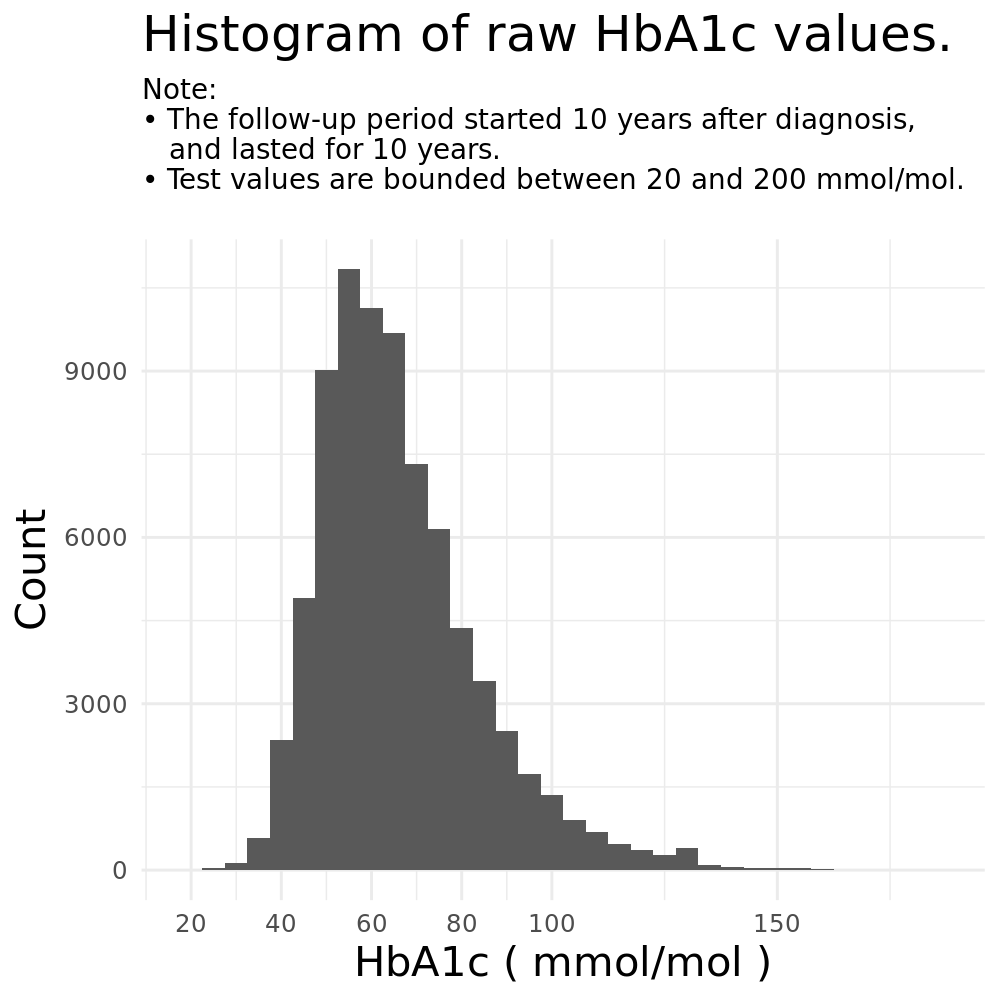

In [8]:
# Plot histogram.
options( repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200 )

dataset %>%
ggplot( aes( x = HbA1c ) ) +
geom_histogram( binwidth = 5 ) +
labs(
    title = "Histogram of raw HbA1c values."
    ,subtitle = paste0(
        "Note: \n"
        ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for ", followup_duration_in_years," years.\n")
        ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
        )
    ,x = "HbA1c ( mmol/mol )"
    ,y = "Count"
) +
scale_x_continuous( breaks = c( seq( 0, 100, 20), 150, 200 ) ) +
theme_minimal() +
theme(
    title = element_text( size = 15 )
    ,plot.subtitle = element_text( size = 10 )
    )

The HbA1c values are clearly skewed to higher values, thus violating the assumption of a Gaussian distribution that would be used in many modelling approaches.

Below, I show the distribution of logged values of HbA1c, which shows a log-Normal distribution. I also show the Bayesian Information Criterion for the Gaussian / Normal and log-Normal fits, which show that assuming a log-Normal distribution provides for a better fit (i.e. a lower value for the BIC).

Going forward, it would be sensible to model HbA1c values on the log scale.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] "The BIC fit statistic assuming a Gaussian distribution is..."


[1] 669655.7

[1] "The BIC fit statistic assuming a log-Normal distribution is..."


[1] 655366.6

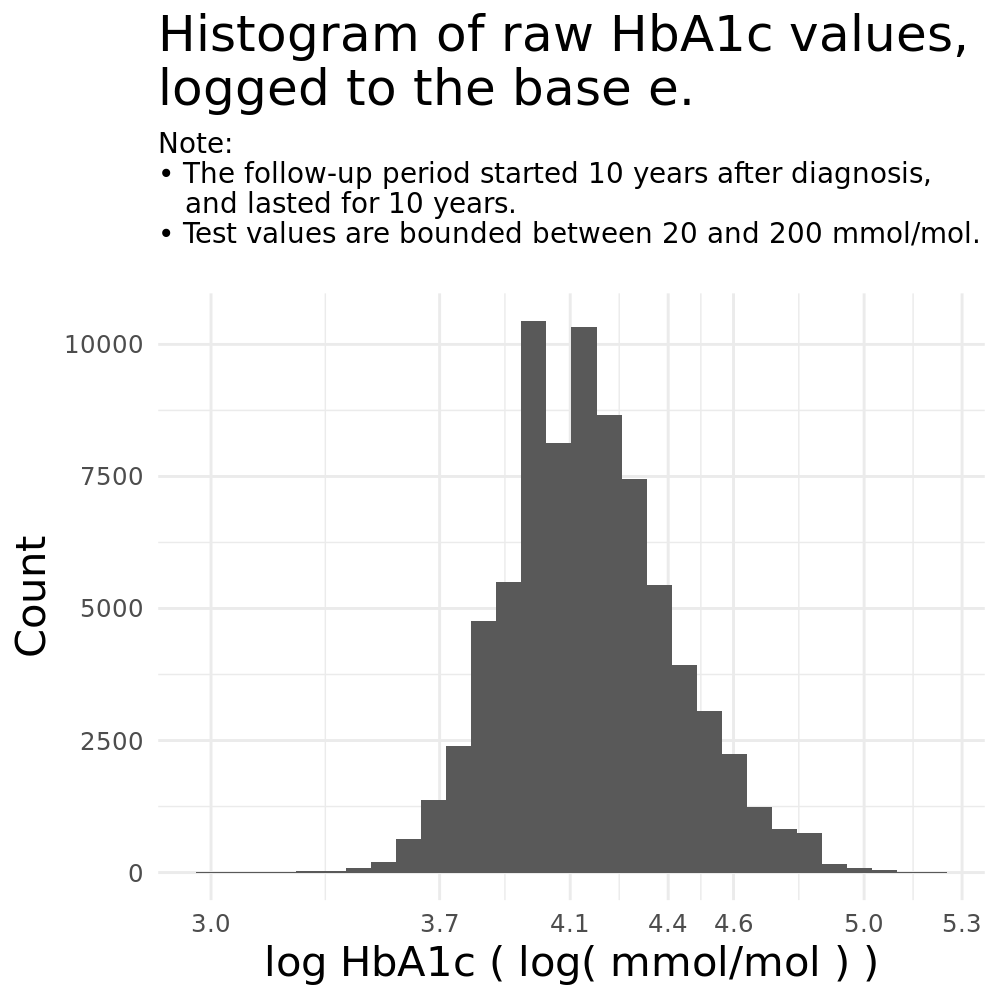

In [9]:
# Plot histogram.
options( repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200 )

dataset <-
dataset %>%
dplyr::mutate(
    HbA1c_log = HbA1c %>% log
    ,Current_HbA1c_log = Current_HbA1c %>% log
    ,Previous_HbA1c_log = Previous_HbA1c %>% log
    )

dataset %>%
ggplot( aes( x = HbA1c_log  ) ) +
geom_histogram( ) +
labs(
    title = "Histogram of raw HbA1c values,\nlogged to the base e."
    ,subtitle = paste0(
        "Note: \n"
        ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for ", followup_duration_in_years," years.\n")
        ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
        )
    ,x = "log HbA1c ( log( mmol/mol ) )"
    ,y = "Count"
) +
scale_x_continuous( breaks = c( 0, c( seq(20, 100, 20), 150, 200 ) %>% log() ) %>% round(1) ) +
theme_minimal() +
theme(
    title = element_text( size = 15 )
    ,plot.subtitle = element_text( size = 10 )
    )

a <- dataset %>%
dplyr::select( HbA1c ) %>%
dplyr::pull()

print("The BIC fit statistic assuming a Gaussian distribution is...")
norm <- fitdistrplus::fitdist( a, "norm" )
norm %>% summary() %>% pluck("bic")

print("The BIC fit statistic assuming a log-Normal distribution is...")
lnorm <- fitdistrplus::fitdist( a, "lnorm" )
lnorm %>% summary() %>% pluck("bic")

rm( a )

# Visual exploration of candidate 'predictors'.
I plot the variate (i.e. HbA1c) as a function of candidate 'predictors' to get an impression of whether or not there is a univariable relationship. I include a gradient for inter-test duration in the plots of the continuous candidate 'predictors' to see if there if the duration between subsequent tests might explain any relationships.

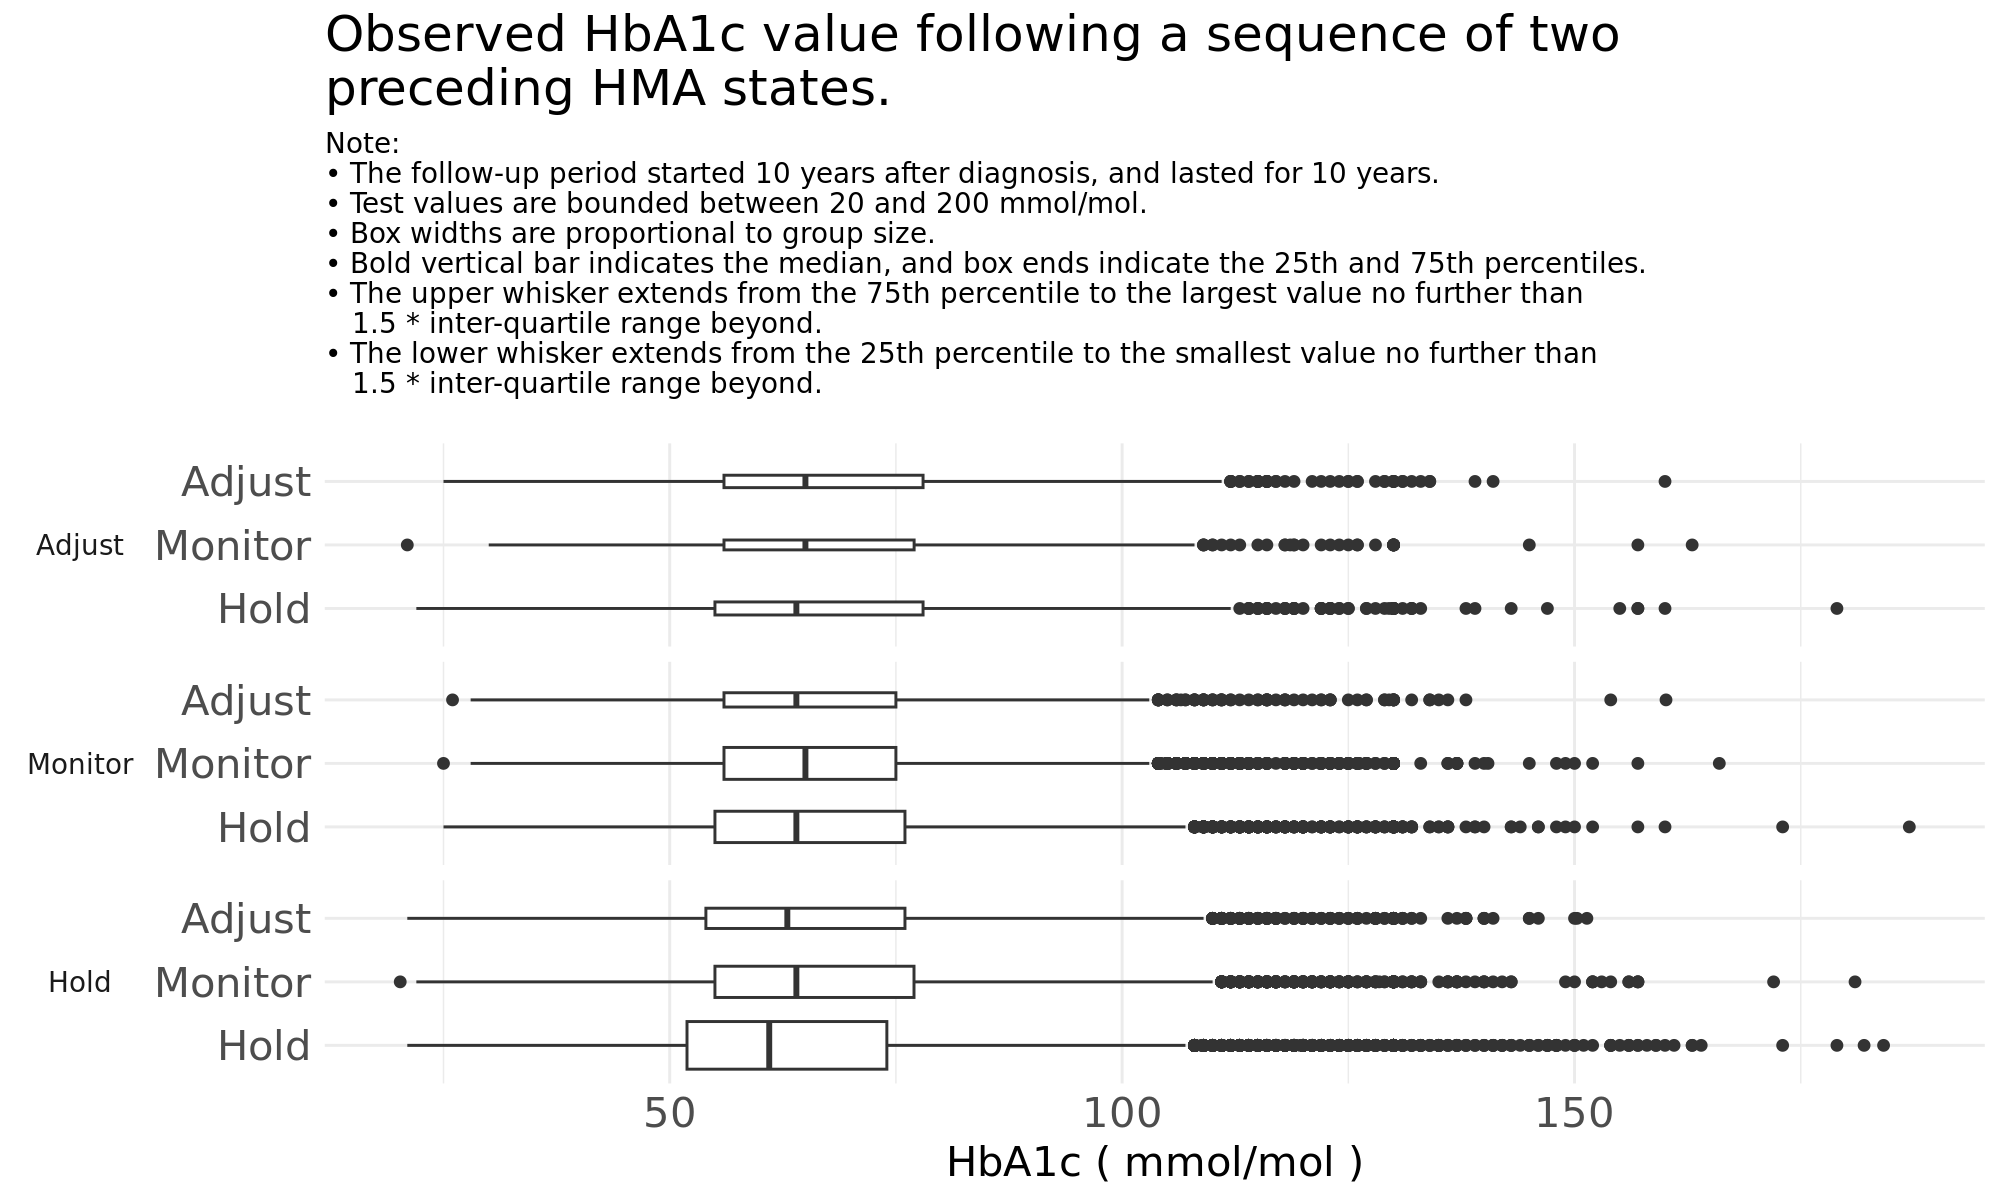

In [10]:
options( repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200 )

# Plot the estimated means.
plot_observed_HbA1c_by_HMA <-
    dataset %>%
    tidyr::drop_na() %>%
    ggplot(
        aes( x = Current_HMA, y = HbA1c )
    ) +
    geom_boxplot( varwidth = TRUE ) +
    labs(
        title = "Observed HbA1c value following a sequence of two\npreceding HMA states."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis, and lasted for ", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            ,"\u2022 Box widths are proportional to group size.\n"
            ,"\u2022 Bold vertical bar indicates the median, and box ends indicate the 25th and 75th percentiles.\n"
            ,"\u2022 The upper whisker extends from the 75th percentile to the largest value no further than\n   1.5 * inter-quartile range beyond.\n"
            ,"\u2022 The lower whisker extends from the 25th percentile to the smallest value no further than\n   1.5 * inter-quartile range beyond.\n"
            )
        ,y = "HbA1c ( mmol/mol )"
    ) +
    facet_grid( rows = vars( fct_rev( Next_HMA ) ), switch = "both", scales = "free_x", space = "free_x") +
    coord_flip() +
    guides( shape = guide_legend( reverse = TRUE, override.aes = list( size = 5 ) ), size = 'none' ) +
    theme_minimal() +
    theme(
        title = element_text( size = 15 )
        ,strip.placement = "outside"
        ,strip.text.y.left = element_text( size = 10, angle = 0 )
        ,axis.title.y = element_blank()
        ,plot.subtitle = element_text( size = 10 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,axis.text = element_text( size = 15 )
    )


plot_observed_HbA1c_by_HMA

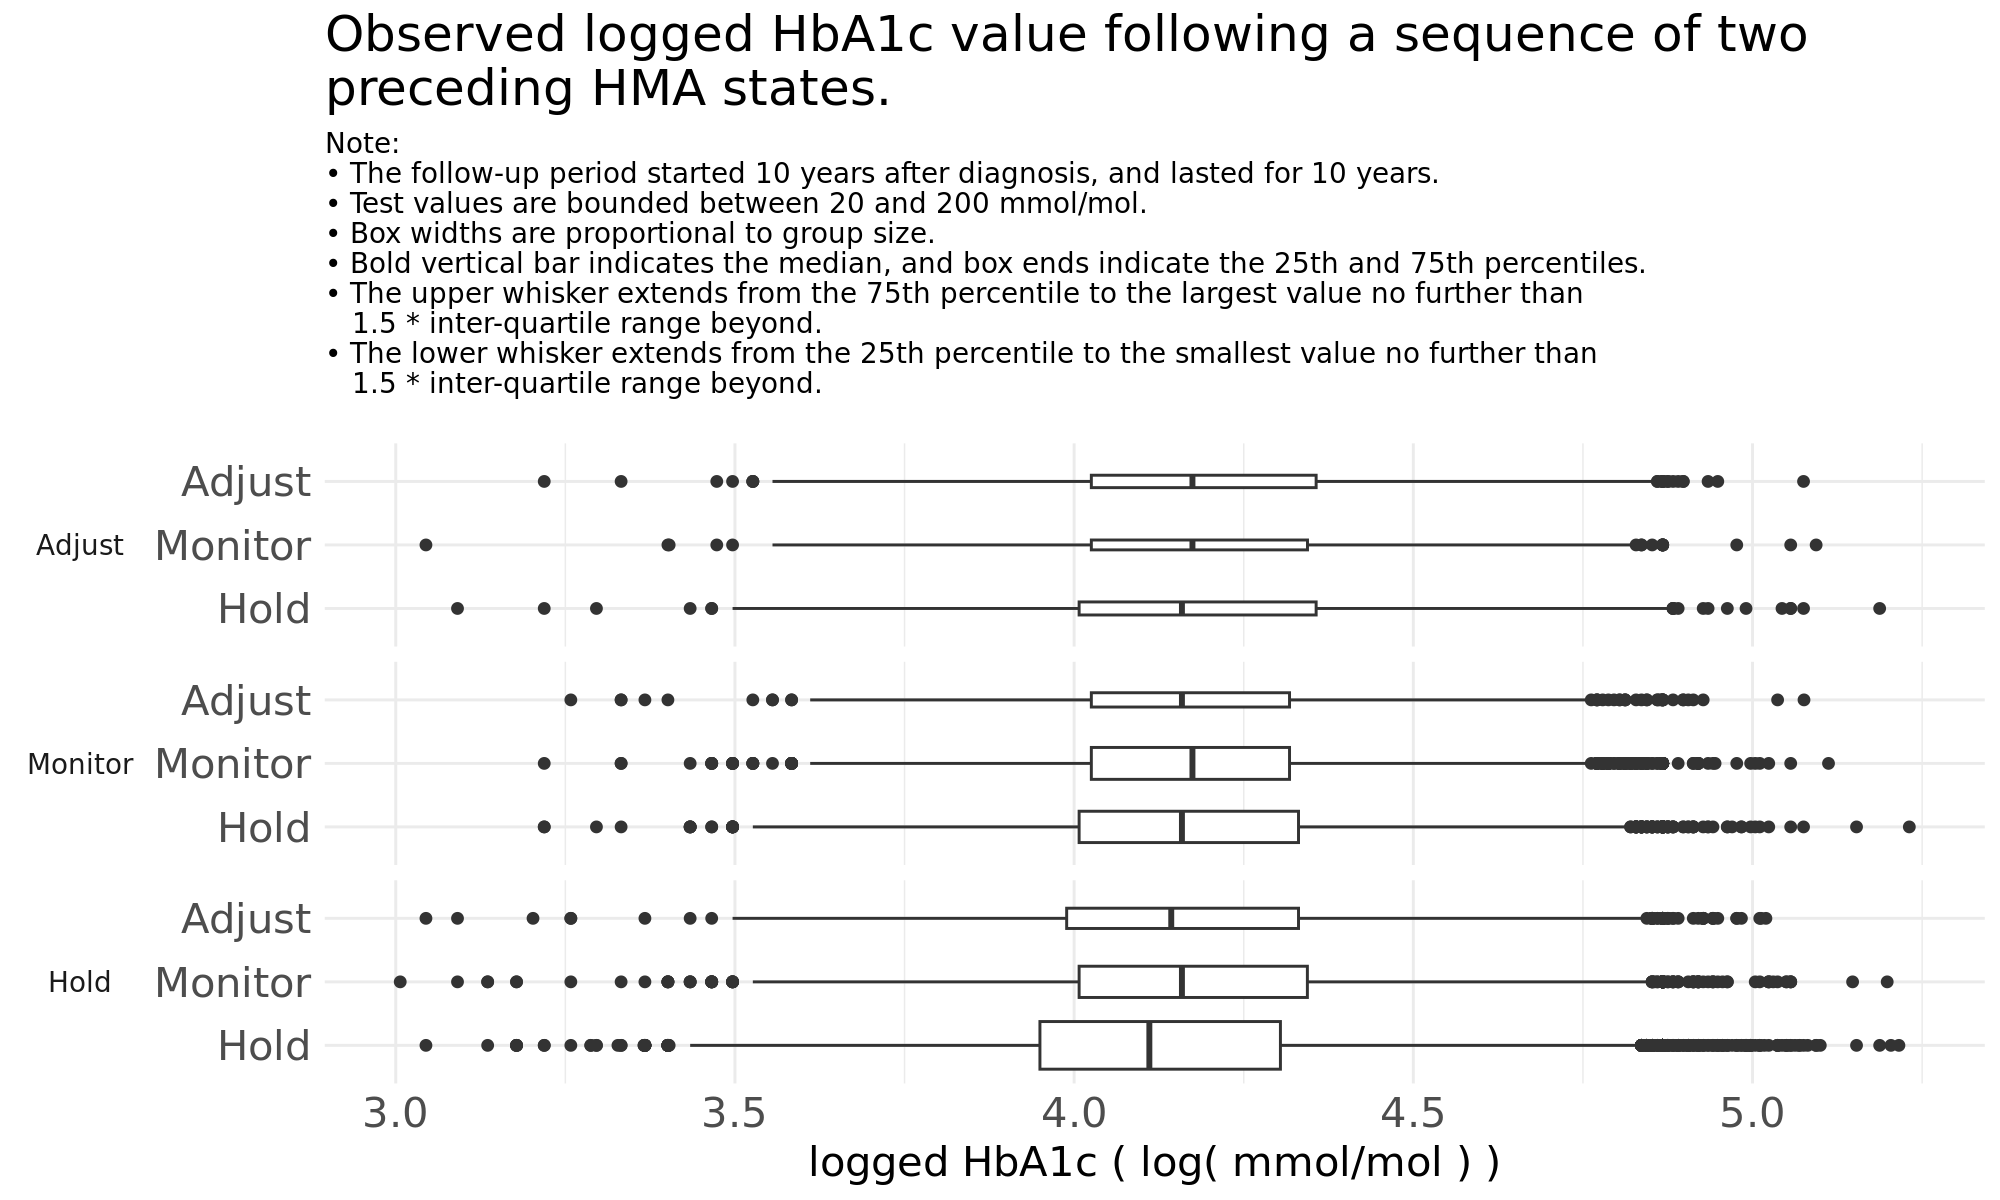

In [11]:
options( repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200 )

# Plot the estimated means.
plot_observed_loggedHbA1c_by_HMA <-
    dataset %>%
    tidyr::drop_na() %>%
    ggplot(
        aes( x = Current_HMA, y = HbA1c_log )
    ) +
    geom_boxplot( varwidth = TRUE ) +
    labs(
        title = "Observed logged HbA1c value following a sequence of two\npreceding HMA states."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis, and lasted for ", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            ,"\u2022 Box widths are proportional to group size.\n"
            ,"\u2022 Bold vertical bar indicates the median, and box ends indicate the 25th and 75th percentiles.\n"
            ,"\u2022 The upper whisker extends from the 75th percentile to the largest value no further than\n   1.5 * inter-quartile range beyond.\n"
            ,"\u2022 The lower whisker extends from the 25th percentile to the smallest value no further than\n   1.5 * inter-quartile range beyond.\n"
            )
        ,y = "logged HbA1c ( log( mmol/mol ) )"
    ) +
    facet_grid( rows = vars( fct_rev( Next_HMA ) ), switch = "both", scales = "free_x", space = "free_x") +
    coord_flip() +
    guides( shape = guide_legend( reverse = TRUE, override.aes = list( size = 5 ) ), size = 'none' ) +
    theme_minimal() +
    theme(
        title = element_text( size = 15 )
        ,strip.placement = "outside"
        ,strip.text.y.left = element_text( size = 10, angle = 0 )
        ,axis.title.y = element_blank()
        ,plot.subtitle = element_text( size = 10 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,axis.text = element_text( size = 15 )
    )


plot_observed_loggedHbA1c_by_HMA

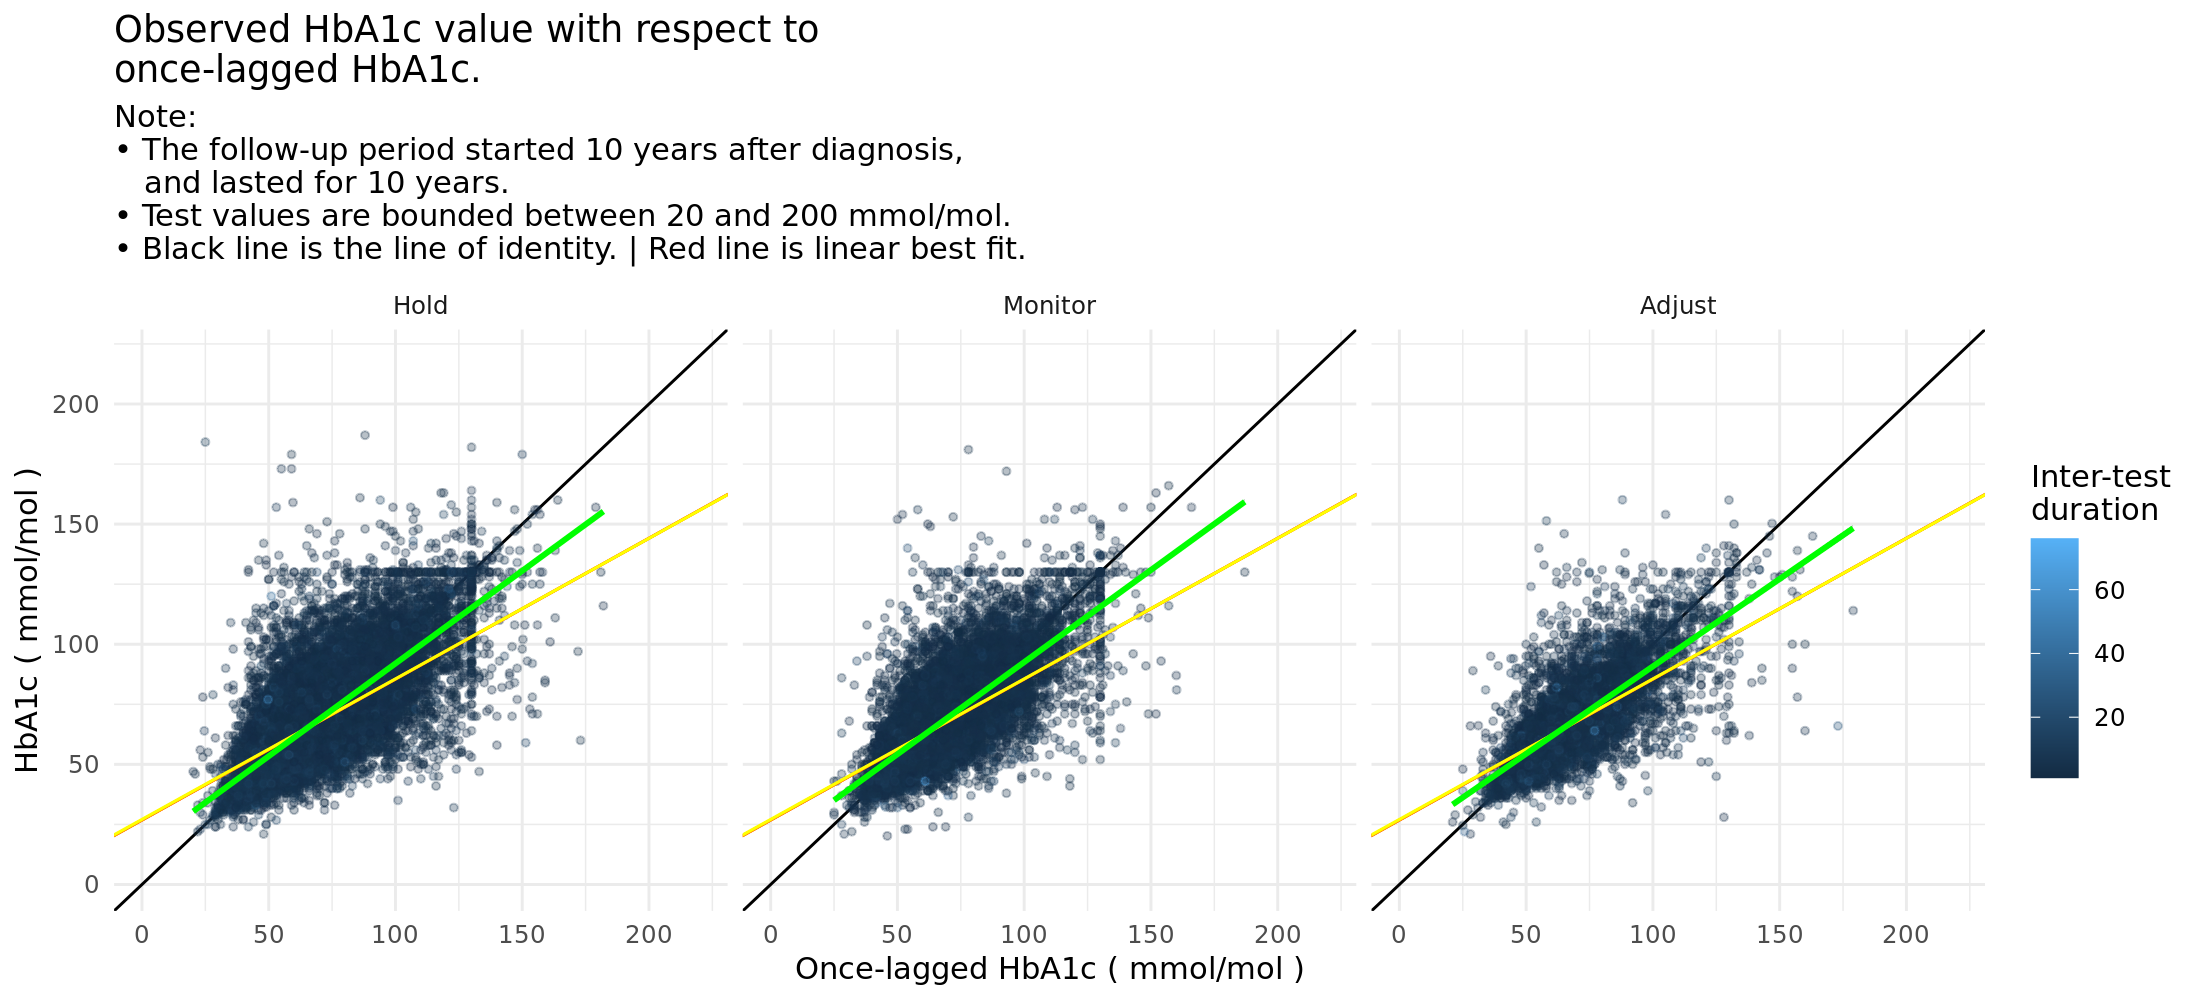

In [16]:
options( repr.plot.width = 11, repr.plot.height = 5, repr.plot.res = 200 )
my_transparency <- 0.3

# Plot for HbA1c vs once-lagged HbA1c.
## Calculate the linear line of best fit.
fit_coeffs_1 <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c ~ Current_HbA1c + Current_HMA + ( 1 | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
fit_coeffs_2 <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c ~ Current_HbA1c + Current_HMA + ( 1 | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
fit_coeffs_3 <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c ~ Current_HbA1c + ( 1 + Current_HMA | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
## Plot.
plot_observed_HbA1c_by_Current_HbA1c <-
    dataset %>% # dplyr::filter( HbA1c != 130 ) %>% dplyr::filter( Current_HbA1c != 130 ) %>% ## Uncomment to remove the ceiling effect at 130 mmol/mol.
    tidyr::drop_na() %>%
    ggplot(
        aes( x = Current_HbA1c, y = HbA1c, colour = inter_test_duration_cont, group = Current_HMA )
    ) +
    # Add reference line.
    geom_abline(intercept = 0, slope = 1) +
    # Plot data points.
    geom_point( size = 1, alpha = my_transparency ) +
    # Add random-intercept line of best fit, assuming fixed effect for once-lagged HbA1c.
    geom_abline( intercept = fit_coeffs_1[1], slope = fit_coeffs_1[2], colour = "red" ) +
    # Add random-intercept line of best fit, assuming fixed effect for once-lagged HbA1c and for once-lagged HMA.
    geom_abline( intercept = fit_coeffs_2[1], slope = fit_coeffs_2[2], colour = "orange" ) +
    # Add random-intercept line of best fit, assuming fixed effect for once-lagged HbA1c, and a correlated random slope for once-lagged HMA.
    geom_abline( intercept = fit_coeffs_3[1], slope = fit_coeffs_3[2], colour = "yellow" ) +
    # Add line of best fit that ignores the dependency between particular patients' repeated observations.
    geom_smooth( method = "lm", colour = "green", formula = 'y ~ x' ) +
    # Aesthetics.
    labs(
        title = "Observed HbA1c value with respect to\nonce-lagged HbA1c."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for ", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            ,paste0("\u2022 Black line is the line of identity. | Red line is linear best fit.")
            )
        ,y = "HbA1c ( mmol/mol )"
        ,x = "Once-lagged HbA1c ( mmol/mol )"
        ,colour = "Inter-test\nduration"
    ) +
    xlim( max( 0, test_value_cutoff_lower*-1.1 ), test_value_cutoff_upper*1.1 ) +
    ylim( max( 0, test_value_cutoff_lower*-1.1 ), test_value_cutoff_upper*1.1 ) +
    theme_minimal() +
    # Stratify by the HMA status of the once-lagged HbA1c test event.
    facet_wrap( ~Current_HMA )

plot_observed_HbA1c_by_Current_HbA1c
ggsave("Stratifying those plots by HMA.png", width = 11, height = 5, units = "in")

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


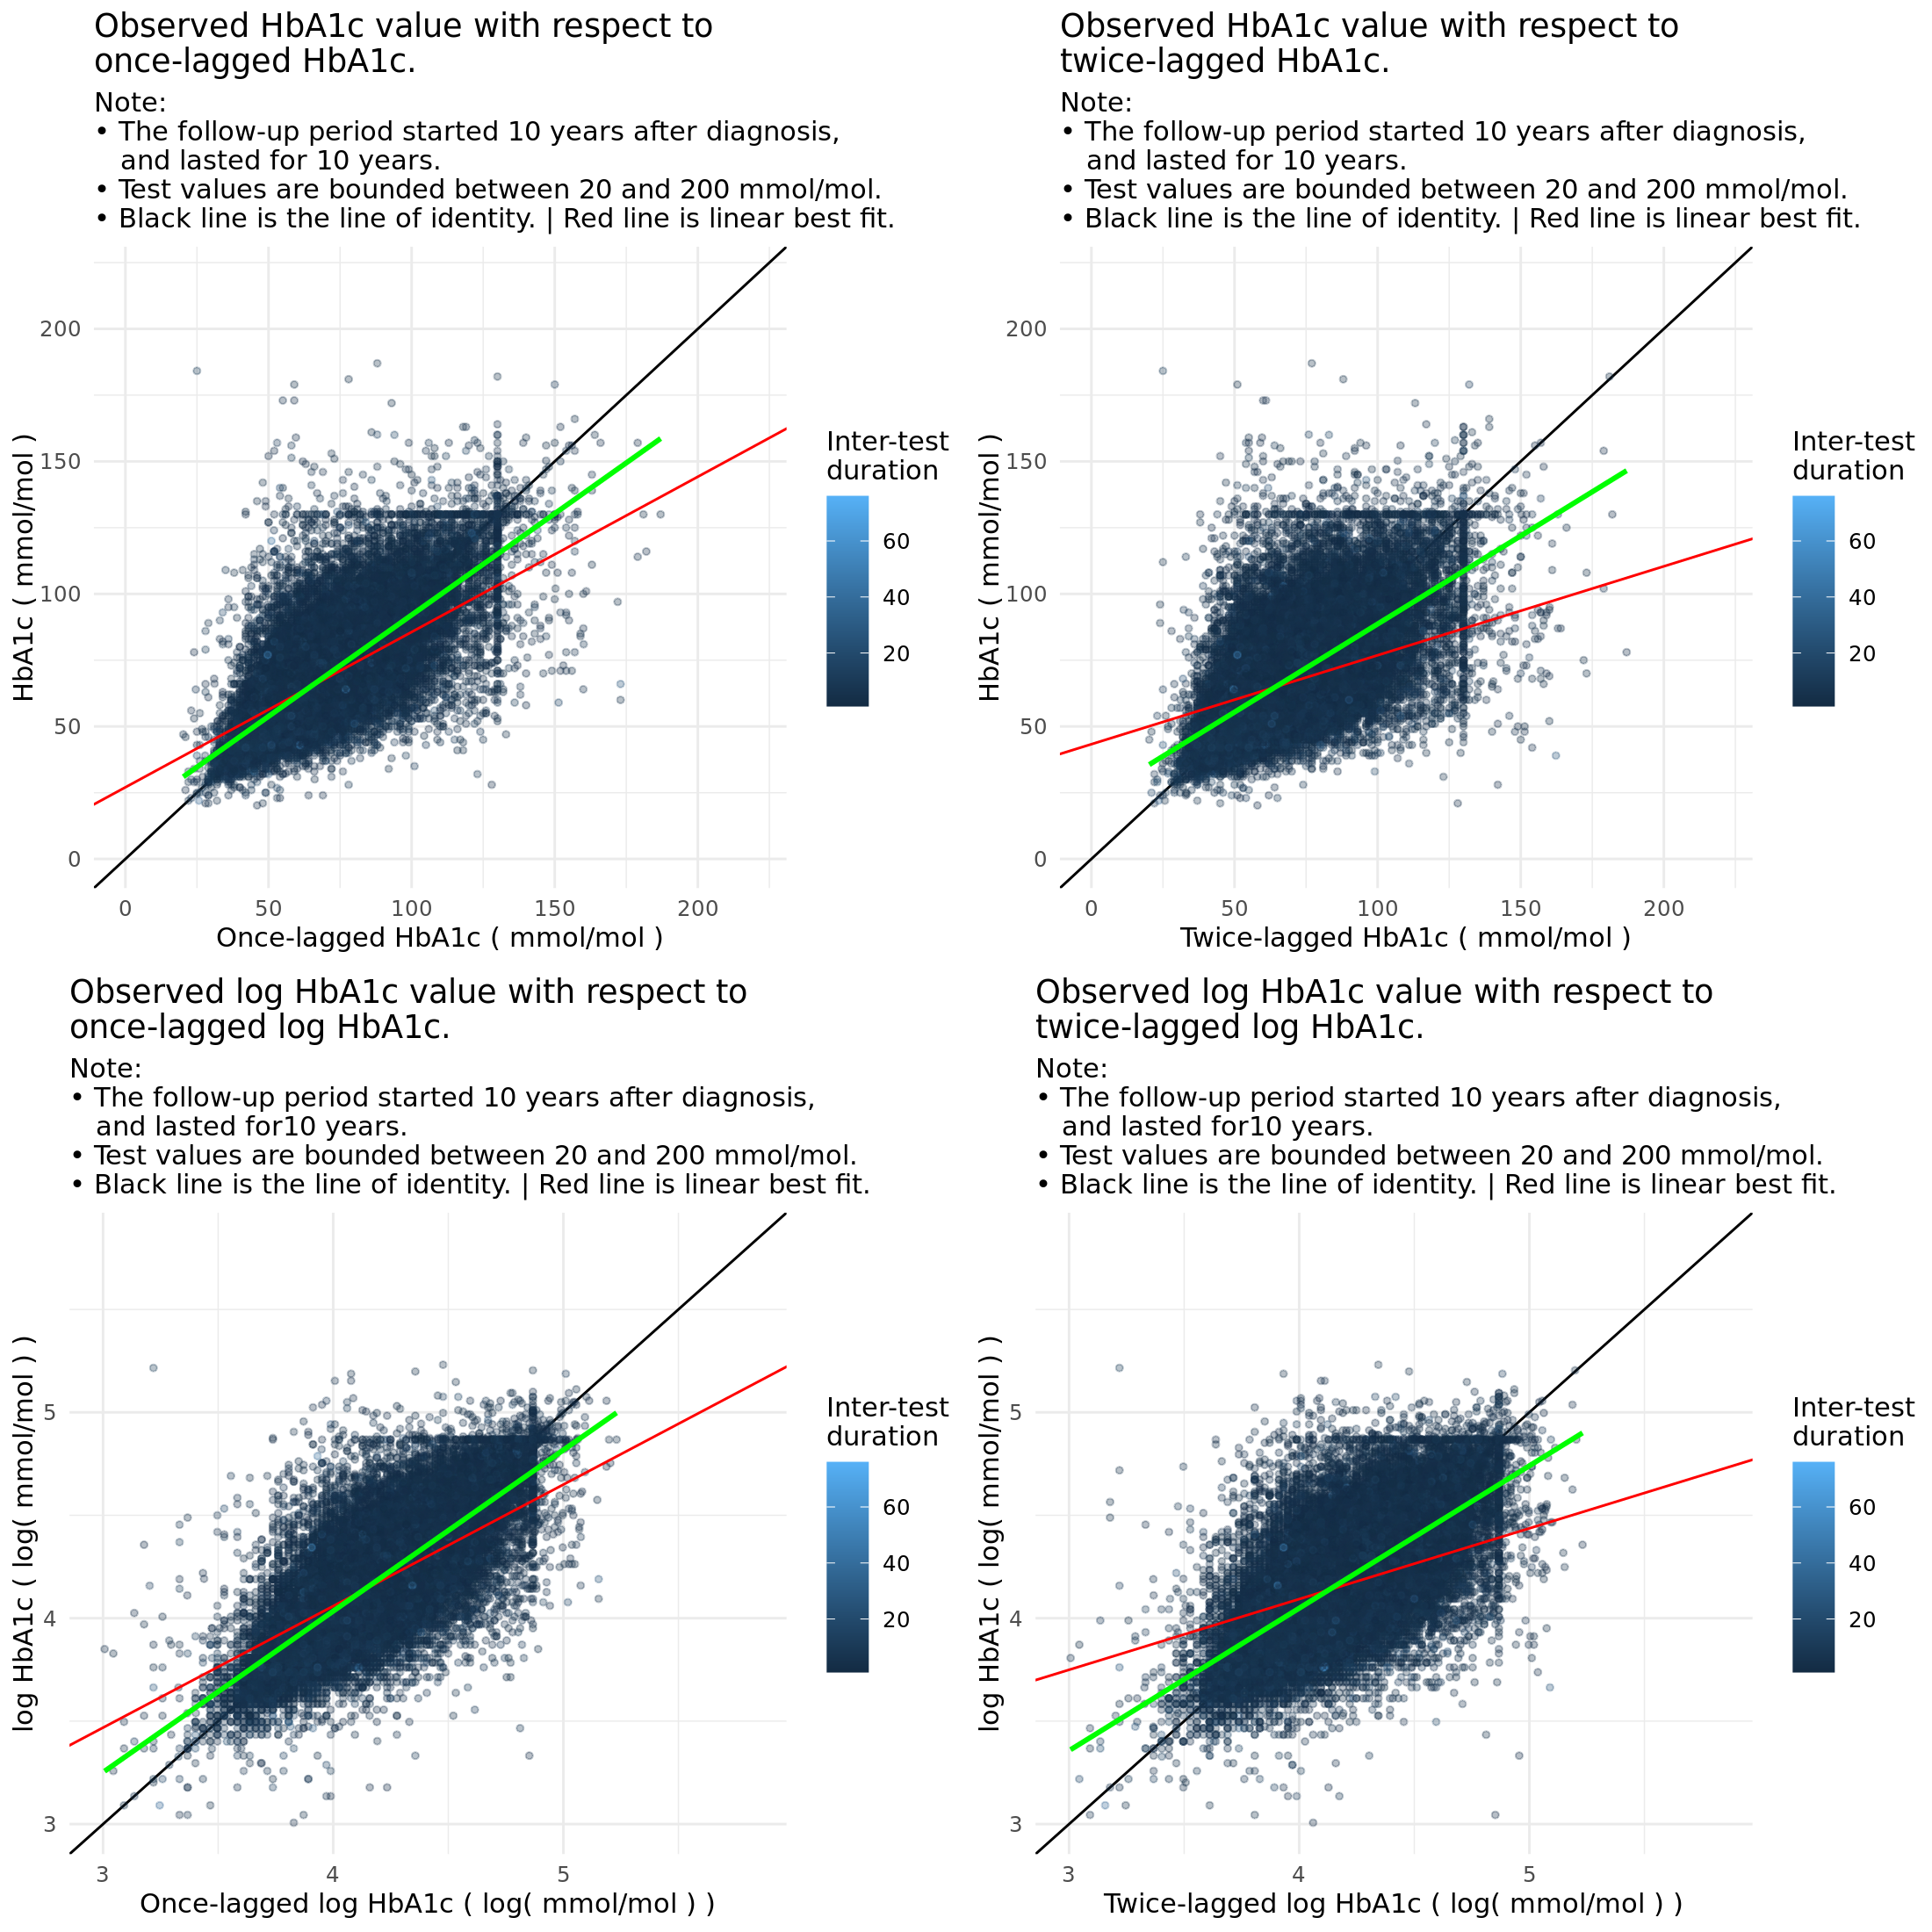

In [10]:
options( repr.plot.width = 11, repr.plot.height = 11, repr.plot.res = 200 )
my_transparency <- 0.3

# Plot for HbA1c vs once-lagged HbA1c.
## Calculate the linear line of best fit.
fit_coeffs <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c ~ Current_HbA1c + ( 1 | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
## Plot.
plot_observed_HbA1c_by_Current_HbA1c <-
    dataset %>% # dplyr::filter( HbA1c != 130 ) %>% dplyr::filter( Current_HbA1c != 130 ) %>% ## Uncomment to remove the ceiling effect at 130 mmol/mol.
    tidyr::drop_na() %>%
    ggplot(
        aes( x = Current_HbA1c, y = HbA1c, colour = inter_test_duration_cont )
    ) +
    geom_abline(intercept = 0, slope = 1) +
    geom_point( size = 1, alpha = my_transparency ) +
    geom_abline( intercept = fit_coeffs[1], slope = fit_coeffs[2], colour = "red" ) +
    geom_smooth( method = "lm", colour = "green", formula = y ~ x ) +
    labs(
        title = "Observed HbA1c value with respect to\nonce-lagged HbA1c."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for ", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            ,paste0("\u2022 Black line is the line of identity. | Red line is linear best fit.")
            )
        ,y = "HbA1c ( mmol/mol )"
        ,x = "Once-lagged HbA1c ( mmol/mol )"
        ,colour = "Inter-test\nduration"
    ) +
    xlim( max( 0, test_value_cutoff_lower*-1.1 ), test_value_cutoff_upper*1.1 ) +
    ylim( max( 0, test_value_cutoff_lower*-1.1 ), test_value_cutoff_upper*1.1 ) +
    theme_minimal() + facet_wrap(~Current_HMA)


# Plot for HbA1c vs twice-lagged HbA1c.
# Calculate the linear line of best fit.
fit_coeffs <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c ~ Previous_HbA1c + ( 1 | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
# Plot.
plot_observed_HbA1c_by_Previous_HbA1c <-
    dataset %>% # dplyr::filter( HbA1c != 130 ) %>% dplyr::filter( Previous_HbA1c != 130 ) %>% ## Uncomment to remove the ceiling effect at 130 mmol/mol.
    tidyr::drop_na() %>%
    ggplot(
        aes( x = Previous_HbA1c, y = HbA1c, colour = inter_test_duration_cont )
        ) +
    geom_abline(intercept = 0, slope = 1) +
    geom_point( size = 1, alpha = my_transparency ) +
    geom_abline( intercept = fit_coeffs[1], slope = fit_coeffs[2], colour = "red" ) +

    geom_smooth( method = "lm", colour = "green", formula = y ~ x ) +
    labs(
        title = "Observed HbA1c value with respect to\ntwice-lagged HbA1c."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for ", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            ,paste0("\u2022 Black line is the line of identity. | Red line is linear best fit.")
            )
        ,y = "HbA1c ( mmol/mol )"
        ,x = "Twice-lagged HbA1c ( mmol/mol )"
        ,colour = "Inter-test\nduration"
    ) +
    xlim( max( 0, test_value_cutoff_lower*-1.1 ), test_value_cutoff_upper*1.1 ) +
    ylim( max( 0, test_value_cutoff_lower*-1.1 ), test_value_cutoff_upper*1.1 ) +
    theme_minimal() 


# Plot for log HbA1c vs twice-lagged log HbA1c.
## Calculate the linear line of best fit.
fit_coeffs <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c_log ~ Current_HbA1c_log + ( 1 | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
## Plot.
plot_observed_logHbA1c_by_Current_logHbA1c <-
    dataset %>% # dplyr::filter( HbA1c != 130 ) %>% dplyr::filter( Current_HbA1c != 130 ) %>% ## Uncomment to remove the ceiling effect at 130 mmol/mol.
    tidyr::drop_na() %>%
    ggplot(
        aes( x = Current_HbA1c_log, y = HbA1c_log, colour = inter_test_duration_cont )
    ) +
    geom_abline( intercept = 0, slope = 1 ) +
    geom_point( size = 1, alpha = my_transparency ) +
    geom_abline( intercept = fit_coeffs[1], slope = fit_coeffs[2], colour = "red" ) +

    geom_smooth( method = "lm", colour = "green", formula = y ~ x ) +
    labs(
        title = "Observed log HbA1c value with respect to\nonce-lagged log HbA1c."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            ,paste0("\u2022 Black line is the line of identity. | Red line is linear best fit.")
            )
        ,y = "log HbA1c ( log( mmol/mol ) )"
        ,x = "Once-lagged log HbA1c ( log( mmol/mol ) )"
        ,colour = "Inter-test\nduration"
    ) +
    xlim( max( log( test_value_cutoff_lower ), log( test_value_cutoff_lower )*-1.1 ), log( test_value_cutoff_upper )*1.1 ) +
    ylim( max( log( test_value_cutoff_lower ), log( test_value_cutoff_lower )*-1.1 ), log( test_value_cutoff_upper )*1.1 ) +
    theme_minimal() 

# Plot for log HbA1c vs twice-lagged log HbA1c.
## Calculate the linear line of best fit.
fit_coeffs <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c_log ~ Previous_HbA1c_log + ( 1 | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
# Plot.
plot_observed_logHbA1c_by_Previous_logHbA1c <-
    dataset %>% # dplyr::filter( HbA1c != 130 ) %>% dplyr::filter( Previous_HbA1c != 130 ) %>% ## Uncomment to remove the ceiling effect at 130 mmol/mol.
    tidyr::drop_na() %>%
    ggplot(
        aes( x = Previous_HbA1c_log, y = HbA1c_log, colour = inter_test_duration_cont )
        ) +
    geom_abline(intercept = 0, slope = 1) +
    geom_point( size = 1, alpha = my_transparency ) +
    geom_abline( intercept = fit_coeffs[1], slope = fit_coeffs[2], colour = "red" ) +

    geom_smooth( method = "lm", colour = "green", formula = y ~ x ) +
    labs(
        title = "Observed log HbA1c value with respect to\ntwice-lagged log HbA1c."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            ,paste0("\u2022 Black line is the line of identity. | Red line is linear best fit.")
            )
        ,y = "log HbA1c ( log( mmol/mol ) )"
        ,x = "Twice-lagged log HbA1c ( log( mmol/mol ) )"
        ,colour = "Inter-test\nduration"
    ) +
    xlim( max( log( test_value_cutoff_lower ), log( test_value_cutoff_lower )*-1.1 ), log( test_value_cutoff_upper )*1.1 ) +
    ylim( max( log( test_value_cutoff_lower ), log( test_value_cutoff_lower )*-1.1 ), log( test_value_cutoff_upper )*1.1 ) +
    theme_minimal() 


cowplot::plot_grid(
    plot_observed_HbA1c_by_Current_HbA1c
    ,plot_observed_HbA1c_by_Previous_HbA1c
    ,plot_observed_logHbA1c_by_Current_logHbA1c
    ,plot_observed_logHbA1c_by_Previous_logHbA1c
    ,nrow = 2
)

rm( fit_coeffs )

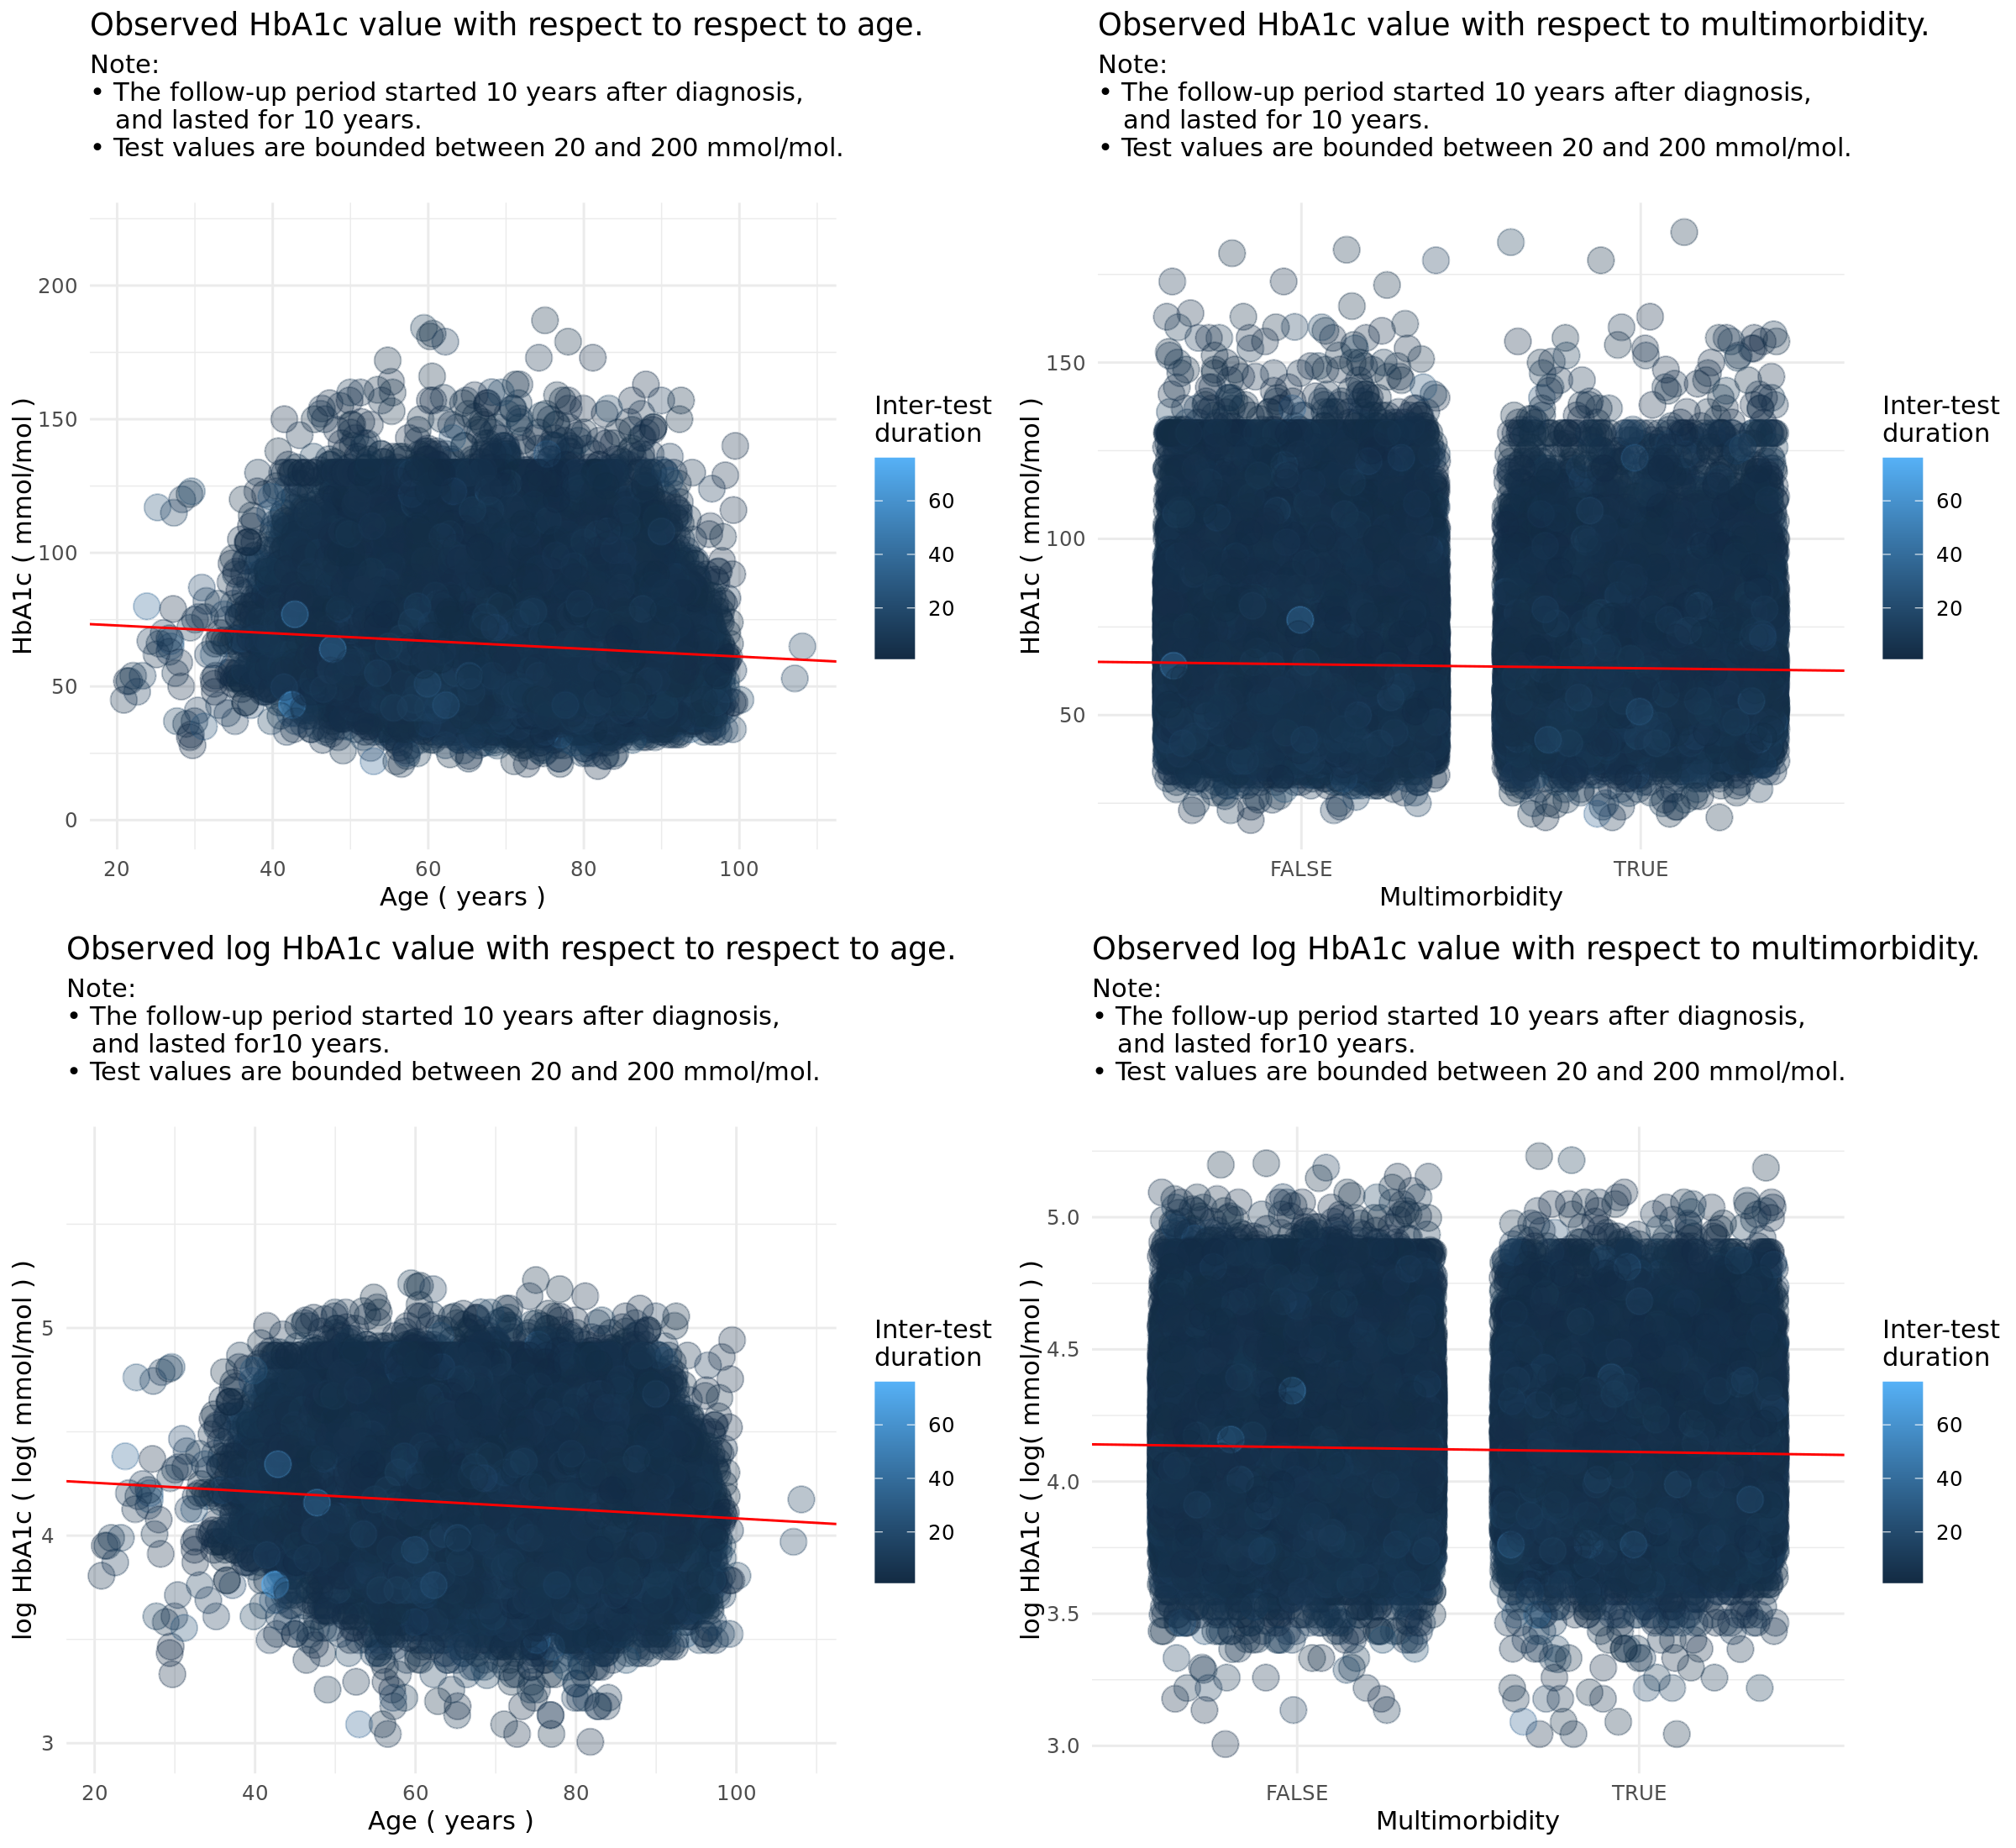

In [11]:
options( repr.plot.width = 12, repr.plot.height = 11, repr.plot.res = 200 )
my_transparency <- 0.3

# Plot for HbA1c vs age.
## Calculate the linear line of best fit.
fit_coeffs <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c ~ Age + ( 1 | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
## Plot.
plot_observed_HbA1c_by_age <-
    dataset %>%
    tidyr::drop_na() %>%
    ggplot(
        aes( x = Age, y = HbA1c, colour = inter_test_duration_cont )
    ) +
    geom_point( size = 5, alpha = my_transparency ) +
    geom_abline( intercept = fit_coeffs[1], slope = fit_coeffs[2], colour = "red" ) +
    labs(
        title = "Observed HbA1c value with respect to respect to age."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for ", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            )
        ,y = "HbA1c ( mmol/mol )"
        ,x = "Age ( years )"
        ,colour = "Inter-test\nduration"
    ) +
    ylim( max( 0, test_value_cutoff_lower*-1.1 ), test_value_cutoff_upper*1.1 ) +
    theme_minimal() 

# Plot for HbA1c vs multimorbidity.
## Calculate the linear line of best fit.
fit_coeffs <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c ~ MultiMorb + ( 1 | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
## Plot.
plot_observed_HbA1c_by_multiMorb <-
    dataset %>%
    tidyr::drop_na() %>%
    ggplot(
        aes( x = MultiMorb, y = HbA1c, colour = inter_test_duration_cont )
        ) +
    geom_jitter( size = 5, alpha = my_transparency ) +
    geom_abline( intercept = fit_coeffs[1], slope = fit_coeffs[2], colour = "red" ) +
    labs(
        title = "Observed HbA1c value with respect to multimorbidity."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for ", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            )
        ,y = "HbA1c ( mmol/mol )"
        ,x = "Multimorbidity"
        ,colour = "Inter-test\nduration"
    ) +
    theme_minimal() 


# Plot for log HbA1c vs age.
## Calculate the linear line of best fit.
fit_coeffs <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c_log ~ Age + ( 1 | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
## Plot.
plot_observed_logHbA1c_by_age <-
    dataset %>%
    tidyr::drop_na() %>%
    ggplot(
        aes( x = Age, y = HbA1c_log, colour = inter_test_duration_cont )
    ) +
    geom_point( size = 5, alpha = my_transparency ) +
    geom_abline( intercept = fit_coeffs[1], slope = fit_coeffs[2], colour = "red" ) +
    labs(
        title = "Observed log HbA1c value with respect to respect to age."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            )
        ,y = "log HbA1c ( log( mmol/mol ) )"
        ,x = "Age ( years )"
        ,colour = "Inter-test\nduration"
    ) +
    ylim( max( log( test_value_cutoff_lower ), log( test_value_cutoff_lower )*-1.1 ), log( test_value_cutoff_upper )*1.1 ) +
    theme_minimal() 

# Plot for log HbA1c vs multimorbidity.
## Calculate the linear line of best fit.
fit_coeffs <- 
    dataset %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            HbA1c_log ~ MultiMorb + ( 1 | person_id  )
            ,data = .
        ) %>%
    summary() %>%
    coefficients() %>%
    `[`( ,1 )
## Plot.
plot_observed_logHbA1c_by_multiMorb <-
    dataset %>%
    tidyr::drop_na() %>%
    ggplot(
        aes( x = MultiMorb, y = HbA1c_log, colour = inter_test_duration_cont )
        ) +
    geom_jitter( size = 5, alpha = my_transparency ) +
    geom_abline( intercept = fit_coeffs[1], slope = fit_coeffs[2], colour = "red" ) +
    labs(
        title = "Observed log HbA1c value with respect to multimorbidity."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis,\n   and lasted for", followup_duration_in_years," years.\n")
            ,paste0("\u2022 Test values are bounded between ", test_value_cutoff_lower," and ", test_value_cutoff_upper," mmol/mol.\n")
            )
        ,y = "log HbA1c ( log( mmol/mol ) )"
        ,x = "Multimorbidity"
        ,colour = "Inter-test\nduration"
    ) +
    theme_minimal() 


cowplot::plot_grid(
    plot_observed_HbA1c_by_age
    ,plot_observed_HbA1c_by_multiMorb
    ,plot_observed_logHbA1c_by_age
    ,plot_observed_logHbA1c_by_multiMorb
    ,nrow = 2
)

- The plots of raw and logged HbA1c are not much different, qualitatively. This is expected because all I have done is applied a scaling function.

- The plot of HbA1c across lagged HMA states looks mostly sensible, though the very high values are unlikely. The right skew of HbA1c values shown in the overall histogram of HbA1c values is seen in each strata of the raw HbA1c values, but not in the log HbA1c values.

- The plot of HbA1c across lagged HbA1c values is informative in several ways:
    1. There appears to be a saturation threshold at 130 mmol/mol, as indicated by the straight lines, vertically and horizontally. Even when the 130 mmol/mol values are removed, there remains a ceiling effect (or a corner effect, in 2D) after which values are suddenly get sparser.
        - This saturation effect should be modelled explicity, or the model needs to be delimited to values below 130 mmol/mol.
    2. There looks to be a mix of a dense rugby-ball shape of values, and for the raw HbA1c plots, there seems to be a sparser expanding-funnel shape. This could indicate either a mix of patient populations, a mix of HbA1c-testing protocols or equipment, or both.
        - I'd hazard a guess that the rugby-ball shape is a physiological phenomenon whereby test-to-test variance is constrained at extreme ranges because they represent stubborn physiological states with little survivable variance.
        - The expanding-funnel shape might indicate heteroscedasticity, which would require me to explicitly model the variance structure in the model.
    3. The red, linear line of best fit is shallower than the angle of the rugby-ball shape would suggest, for both once-lagged and twice-lagged HbA1c values. This indicates that subsequent HbA1c values are, on average, lower. It is also visually clear that the slope of the linear line of best fit for twice-lagged HbA1c is shallower than for once-lagged HbA1c. This suggests that the magnitude by which subsequent HbA1c values are lower, on average, is greater for twice-subsequent HbA1c values. The phenomenon of regressing to the mean might have explained the once-lagged slope but an even-shallower slope for twice-lagged HbA1c suggests a consistent trend of reducing HbA1c values over time. Regardless of the explanation, the shallow linear lines of best fit mean that such models over-estimate lower values and under-estimate higher values ( Note: The models of the linear line of best fit are GLMMs that used a random intercept for `person_id` to account for the dependency between patients' repeated observations.)
        - The over- and under-estimation can be restated as a linear trend in the model residuals. Fortunately, this linear trend is systematic, which means it can be explicitly modelled. The question will be how to model it: covariate adjusted variance structure, covariate fixed effect?
    4. Zooming into either of the plots and adding a rug visualisation shows that the HbA1c values cluster periodically along the range of values (see rug and the dense regions along the line of identity in the plot below). This might indicate a pattern of bias in the recording of HbA1c values that, ideally, would be modelled explicitly.
        - As yet, I don't have an idea of what the generating phenomenon is, so I do not have an suggestion for how to model this.

- The plot of HbA1c across age suggests that the `Age` variable offers almost no information, in isolation.
    - Including the `Age` variable in the model is unnecessary.

- The plot of HbA1c across multimorbidity suggests that the `MultiMorb` variable offers almost no information, in isolation.
    - Including the `MultiMorb` variable in the model is unnecessary.

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 437 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 437 rows containing missing values or values outside the scale range
(`geom_point()`).”


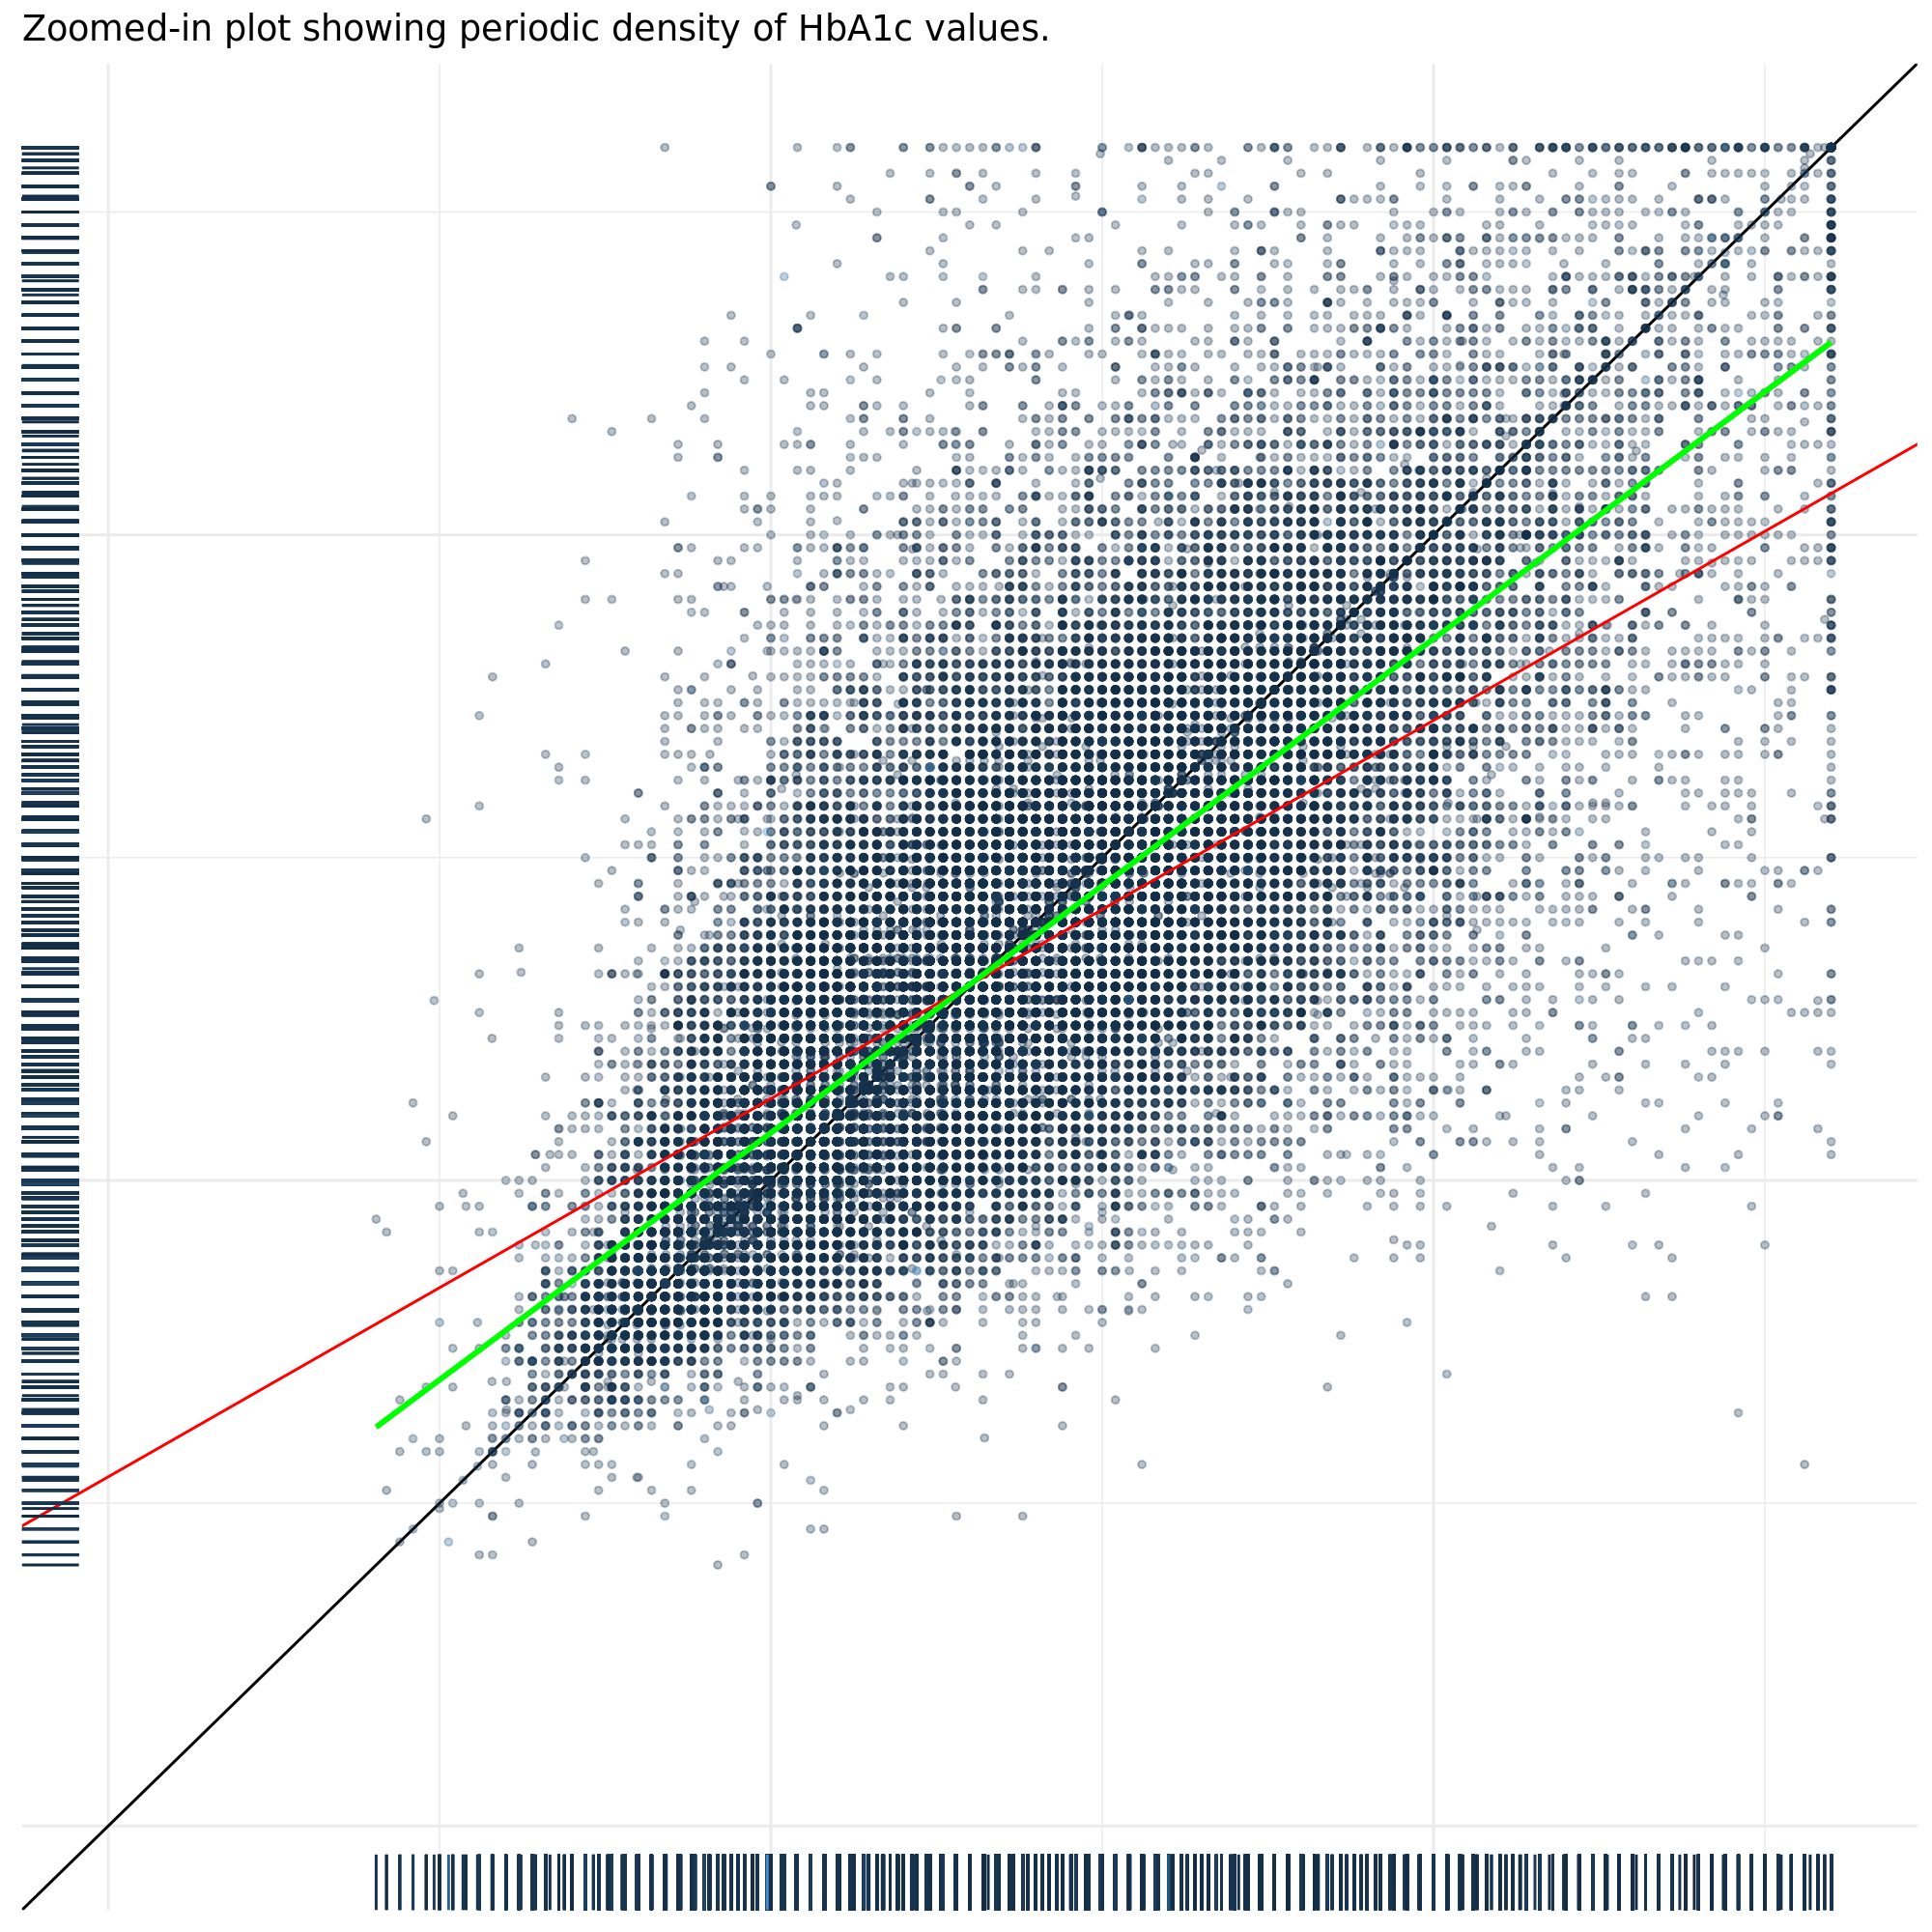

In [12]:
options( repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200 )

plot_observed_HbA1c_by_Current_HbA1c +
geom_rug() +
xlim( 0 , 130 ) +
ylim( 0 , 130 ) +
labs( title = "Zoomed-in plot showing periodic density of HbA1c values." ) +
theme(
    ,axis.title = element_blank()
    ,plot.subtitle = element_blank()
    ,axis.text = element_blank()
    ,legend.position = 'none'
) %>%
suppressWarnings()

# Check for autocorrelation.
The slope of the linear line of best fit in individual plots of lagged HbA1c evidenced autocorrelation. The ACF ( <u>a</u>uto<u>c</u>orrelation <u>f</u>unction ) is the covariance of two observations either end of a sliding window in a sequence, standardised to the (assumed to be) stationary variance of all observations. The value cannot be greater than +1 or -1, but the sign of the value indicates positive or negative autocorrelation. The ACF assumes a Gaussian distribution for the variate so I assess autocorrelation on the log HbA1c values. I also assume a random intercept for `person_id` to respect the nested structure of the data generating process.

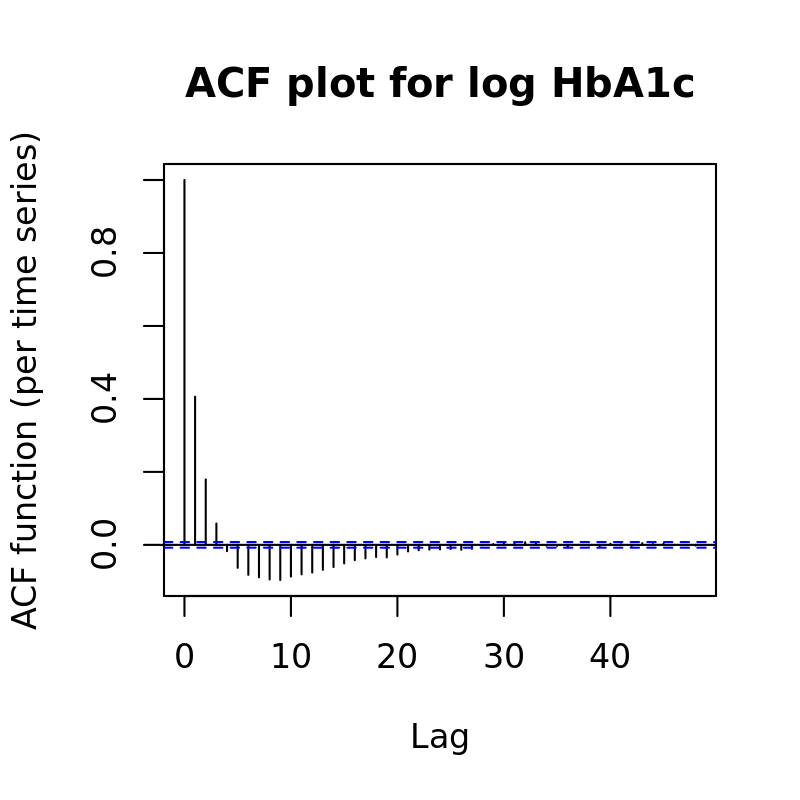

In [13]:
options( repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 200 )

lme4::lmer(
    HbA1c_log ~ ( 1 | person_id )
    ,data = dataset %>% tidyr::drop_na()
) %>%
itsadug::acf_resid( main = "ACF plot for log HbA1c" ) 

The ACF plot shows some small but statistically-significant (at significance level = 0.05) autocorrelation in the HbA1c values as far back as almost the 30th-lagged log HbA1c value, when we nest repeated observations within `person_id`. 

The first vertical line the reference value of 1 for an observation correlating with itself. The thresholds indicated by the two dashed blue lines are the 95% confidence intervals for zero autocorrelation. Any non-zero value for the autocorrelation within these thresholds is compatible with the true value being zero. 

I conclude that there is a need to include lags of log HbA1c in the model, but anything more than the once-lagged log HbA1c value is not likely to contain much information.

# Fit generalised linear mixed model.
Next, I fit several linear mixed models (LMMs) and generalised linear mixed models (GLMMs) to determine the best set of 'predictors' from my shortlist. The LMMs permit me to assess autocorrelation of a covariate-adjusted model. I will assess the inclusion of fixed-effect covariates for age and multimorbidity status.


I will only assess up to twice-lagged covariates because:
1. discussions with a GP colleague (CB) suggested that one typically wouldn't review more than two testing instances prior when making a decision about what to do next because the relevance of test results and patients' health states are transient.
2. as mentioned earlier, the greater the number of lags, the greater the number of observations that are excluded, which also leads to excluding a greater number of patients with a count of records fewer than the number of lags.


It is not likely that including lagged HMA states will contribute to model fit or subsequent 'predictions'. This is because historical HMA states and subsequent HbA1c values are confounded by historical HbA1c values, and do not have any reasonable effect on each other. Thus, any association that they share (in other words, any information that might be conferred between them for prediction) is expected to come entirely from historical HbA1c values. Previous plots of the observed HbA1c values also show very little difference in the median value across strata defined by HMA states. I will include variables representing HMA states only because I want to stratify 'predictions' by histories of HMA states. Fortunately, their inclusion is not likely to be any detriment because historical HMA states and subsequent HbA1c are conditionally indpendent by virtue of including a covariate for lagged HbA1c covariate.

In [14]:
# Fit Gaussian models.
GLMM_intercept_only <-
    lme4::lmer(
        HbA1c_log ~ 1 + ( 1 | person_id  )
        ,data = dataset %>% tidyr::drop_na()
    )
GLMM_intercept_AgeMultiMorb <-
    lme4::lmer(
        HbA1c_log ~ Age + MultiMorb + (1 | person_id )
        ,data = dataset %>% tidyr::drop_na()
    )
LMM_intercept_AR1 <-
    nlme::lme(
        HbA1c_log ~ 1
        ,random = ~ 1 | person_id 
        ,data = dataset %>% tidyr::drop_na()
        ,correlation = nlme::corAR1()
    )
GLMM_oneHbA1c <-
    lme4::lmer(
        HbA1c_log ~ Current_HbA1c_log + ( 1 | person_id  )
        ,data = dataset %>% tidyr::drop_na()
    )
GLMM_twoHbA1c <-
    lme4::lmer(
        HbA1c_log ~ Current_HbA1c_log + Previous_HbA1c_log + ( 1 | person_id  )
        ,data = dataset %>% tidyr::drop_na()
    )
LMM_AR1_oneHMA <-
    nlme::lme(
        HbA1c_log ~ Next_HMA
        ,random = ~ 1 | person_id 
        ,data = dataset %>% tidyr::drop_na()
        ,correlation = nlme::corAR1()
    )
LMM_AR1_twoHMA <-
    nlme::lme(
        HbA1c_log ~ Next_HMA + Current_HMA
        ,random = ~ 1 | person_id 
        ,data = dataset %>% tidyr::drop_na()
        ,correlation = nlme::corAR1()
    )
GLMM_twoHbA1c_oneHMA <-
    lme4::lmer(
        HbA1c_log ~ Current_HbA1c_log + Previous_HbA1c_log + Next_HMA + ( 1 | person_id  )
        ,data = dataset %>% tidyr::drop_na()
    )
GLMM_twoHbA1c_twoHMA <-
    lme4::lmer(
        HbA1c_log ~ Current_HbA1c_log + Previous_HbA1c_log + Next_HMA + Current_HMA + ( 1 | person_id  )
        ,data = dataset %>% tidyr::drop_na()
    )
GLMM_twoHbA1c_twoHMA_AgeMultiMorb <-
    lme4::lmer(
        HbA1c_log ~ Current_HbA1c_log + Previous_HbA1c_log + Next_HMA + Current_HMA + Age + MultiMorb + ( 1 | person_id  )
        ,data = dataset %>% tidyr::drop_na()
    )
GLMM_oneHbA1c_twoHMA <-
    lme4::lmer(
        HbA1c_log ~ Current_HbA1c_log + Next_HMA + Current_HMA + ( 1 | person_id  )
        ,data = dataset %>% tidyr::drop_na()
    )

In [15]:
data.frame(
    model = c(
        "intercept_only"
        ,"intercept_AgeMultiMorb"
        ,"intercept_AR1"
        ,"oneHbA1c"
        ,"twoHbA1c"
        ,"AR1_oneHMA"
        ,"AR1_twoHMA"
        ,"twoHbA1c_oneHMA"
        ,"twoHbA1c_twoHMA"
        ,"twoHbA1c_twoHMA_AgeMultiMorb"
        ,"oneHbA1c_twoHMA"
    )
    ,BIC_GLMM = c(
        BIC( GLMM_intercept_only )
        ,BIC( GLMM_intercept_AgeMultiMorb )
        ,BIC( LMM_intercept_AR1 )
        ,BIC( GLMM_oneHbA1c )
        ,BIC( GLMM_twoHbA1c )
        ,BIC( LMM_AR1_oneHMA )
        ,BIC( LMM_AR1_twoHMA )
        ,BIC( GLMM_twoHbA1c_oneHMA )
        ,BIC( GLMM_twoHbA1c_twoHMA )
        ,BIC( GLMM_twoHbA1c_twoHMA_AgeMultiMorb )
        ,BIC( GLMM_oneHbA1c_twoHMA )
        )
    )

model                        BIC_GLMM 
1  intercept_only               -38145.34
2  intercept_AgeMultiMorb       -38219.33
3  intercept_AR1                -56257.70
4  oneHbA1c                     -59223.66
5  twoHbA1c                     -60458.23
6  AR1_oneHMA                   -56281.27
7  AR1_twoHMA                   -56237.57
8  twoHbA1c_oneHMA              -60463.13
9  twoHbA1c_twoHMA              -60444.03
10 twoHbA1c_twoHMA_AgeMultiMorb -60569.81
11 oneHbA1c_twoHMA              -59224.82

I use the Baysian Information Criteria ( BIC ) as the model fit statistic. Keep in mind that the lower the number, the better the BIC. This means that negative numbers are better than positive numbers, and larger negative numbers are better than smaller positive numbers.

The results table above shows that specifying the lagged HbA1c values is a better fit than the first-order autoregression. This makes sense when one considers the autocorrelation function plot that showed the autocorrelation change from positive to negative, which a first-order autoregression doesn't represent well.

The previous plots of age and multimorbidity suggested that they would do little as main effects. Without the main covariates of lagged log HbA1c, they are detrimental tomodel fit, but in concert with log HbA1c and HMA state, they improve the fit of the model by a small amount.

I conclude that the 'prediction' 'model' should include both once-lagged and twice-lagged values of log HbA1c and the HMA state, and the age and multimorbidity covariates.

# Fit generalised estimating equations.
Finally, I estimate a GEE using `Current_HbA1c_log`, `Previous_HbA1c_log`, `Next_HMA`, `Current_HbA1c`, `Age`, and `MultiMorb` as covariates / 'predictors'. I select an exchangeable covariance structure blocked by `person_id`, which means that I nest observations within `person_id` and each nested observation has the same association with any other (i.e. there is no assumed decay of association that might arise from time ordering, within a patient's repeated observations). I chose the exchangeable covariance structure because the previous assessment of GLMMs with autoregressive covariance structures suggested that they did not account for the serial variance as well as lagged fixed effects (i.e. covariates of lagged log HbA1c). I suggested that this was because the observed autocorrelation did not follow the exponential decay assumed by the autoregessive structure.

In [16]:
GEE_twoHbA1c_twoHMA_AgeMultiMorb <-
    geepack::geeglm(
        HbA1c_log ~ Current_HbA1c_log + Previous_HbA1c_log + Next_HMA + Current_HMA + Age + MultiMorb
        ,id = person_id
        ,corstr = "exchangeable"
        ,data = dataset %>% tidyr::drop_na()
    )

# Check model diagnostics and validity.

## Residuals.
I check the psuedo-residuals to check the assumption of conditional constant variance and serial correlation. There should be no pattern in the residual plot.

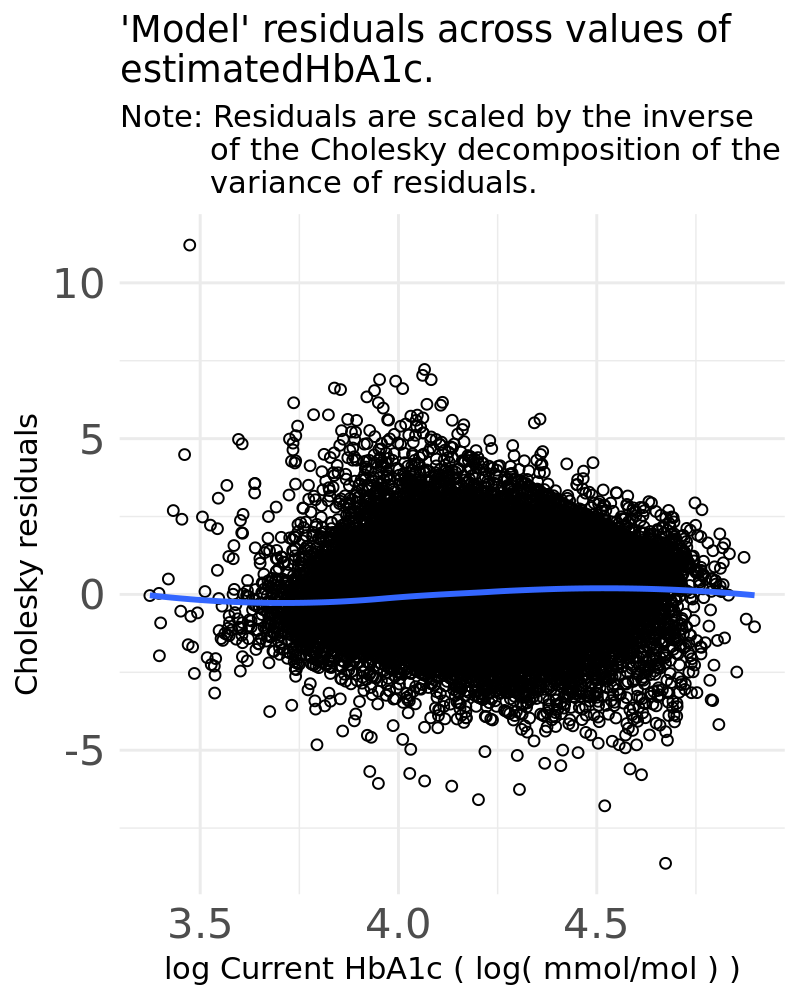

In [17]:
# Calculate the residuals.
# ## source: page 156, https://courses.washington.edu/b571/lectures/set3.pdf
calibration_df <-
    dataset %>%
    tidyr::drop_na() %>%
    dplyr::select( HbA1c_log ) %>%
    `colnames<-`( "obs" ) %>%
    dplyr::bind_cols( pred = predict( GEE_twoHbA1c_twoHMA_AgeMultiMorb ) ) %>%
    dplyr::mutate( diffs = obs - pred )

choleskey_scalar <-
    calibration_df %>%
    dplyr::select( diffs ) %>%
    var() %>%
    chol() %>%
    MASS::ginv()

calibration_df <-
    calibration_df %>%
    dplyr::mutate( chol_diffs = diffs * choleskey_scalar[1])

plot_df <-
    calibration_df %>%
    dplyr::bind_cols( dataset %>% tidyr::drop_na() )


# Make residuals plot.
options( repr.plot.width = 4, repr.plot.height = 5, repr.plot.res = 200 )

plot_residuals <-
    plot_df %>%
        ggplot( aes( x = pred, y = chol_diffs ) ) +
        geom_point( shape = 21 ) +
        labs(
            title = "'Model' residuals across values of\nestimatedHbA1c."
            ,subtitle = "Note: Residuals are scaled by the inverse\n         of the Cholesky decomposition of the\n         variance of residuals."
            ,x = "log Current HbA1c ( log( mmol/mol ) )"
            ,y = "Cholesky residuals"
        ) +
        stat_smooth( method = "loess", formula = y ~ x, se = FALSE ) +
        theme_minimal() +
        theme(
            ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
            ,legend.position = 'none'
            ,axis.text = element_text( size = 15 )
        )

plot_residuals

The residual plot above suggests there is no average trend in the residuals across the range of estimated values. That said, I'd argue there is a downward slope indicating under-estimation at low values and over-estimation at high values.

### Saturation effect.
There appears to be a distinct straight line at the top right, sloping to the bottom right. This is very likely to be a re-presentatio of the saturation effect at 130 mmol/mol (equivalent to 4.8 on the log scale ) that was seen in the plots of HbA1c. The fact that some values exist beyond this saturation means we have a mixed population of observations. In other words, our sample is made up of some observations for which there is a ceiling and some where there is not. This is sensible given that the observations are selected based on satisfying at least one of a set of SNOMED CT codes. It is plausible that observations from some of these codes have a saturation effect while others do not. Unfortunately, almost all observations included in our dataset are from the same SNOMED CT code ( `999791000000106` ), and colour-coding the plots by the SNOMED CT code shows that both the saturated and non-saturated values are from the same, majority SNOMED CT code. Therefore, the SNOMED CT explanation is not sufficient.

Alternatively, the saturation at 130 mmol/mol might be explained by those observations coming from a particular care site. Unfortunately, there are hundreds of care sites in the Connected Bradford database, so it would not be feasible to include `care_site_id` as a covariate (which would have been feasible for the three SNOMED CT codes).


### Residual patterns across covariate values.
Plotting the residuals as a function of covariate values can help to indicate any component patterns that were washed out in the main residual plot.

I start by plotting the residuals as a function of the `Current_HMA` and `Next_HMA`.

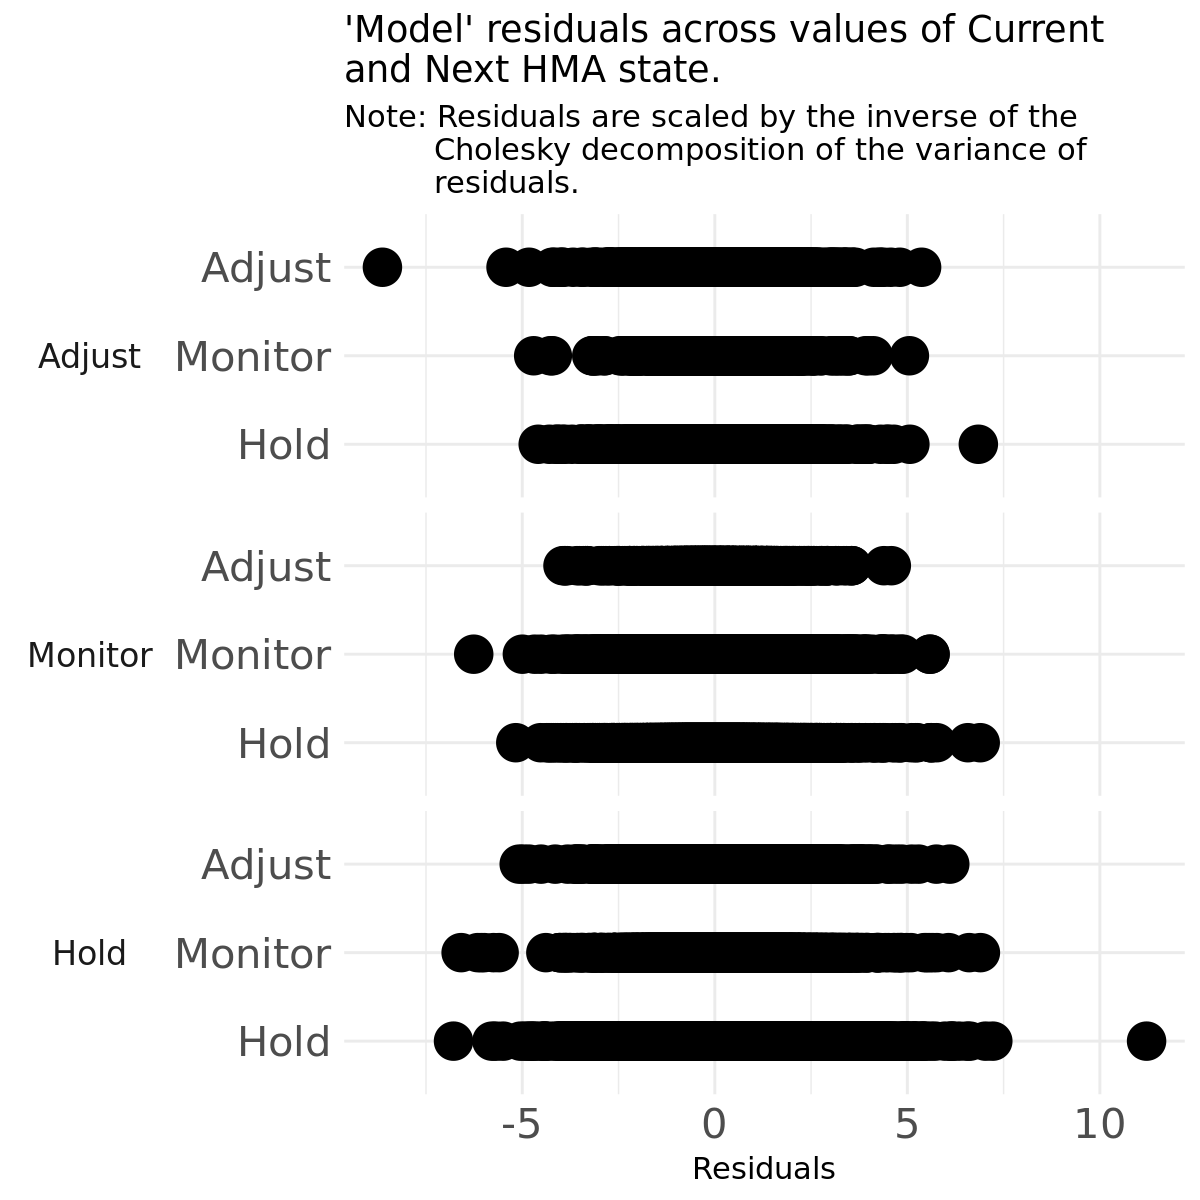

In [18]:
# Make residuals plot.
options( repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 200 )


plot_residuals_HMA <-
    plot_df %>%
    ggplot() +
    geom_point(
        aes( x = Current_HMA, y = chol_diffs )
        ,size = 6
    ) +
    labs(
        title = "'Model' residuals across values of Current\nand Next HMA state."
        ,subtitle = "Note: Residuals are scaled by the inverse of the\n         Cholesky decomposition of the variance of\n         residuals."
        ,y = "Residuals"
    ) +
    facet_grid( rows = vars( fct_rev( Next_HMA ) ), switch = "both", scales = "free_x", space = "free_x") +
    coord_flip() +
    theme_minimal() +
    theme(
        ,strip.placement = "outside"
        ,strip.text.y.left = element_text( size = 12, angle = 0 )
        ,axis.title.y = element_blank()
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,legend.title = element_blank()
        ,legend.position = 'none'
        ,axis.text = element_text( size = 15 )
    )

plot_residuals_HMA

There does not seem to be any pattern of the residuals.


Next, I check any patterns of the residuals with respect to the lagged values of HbA1c.

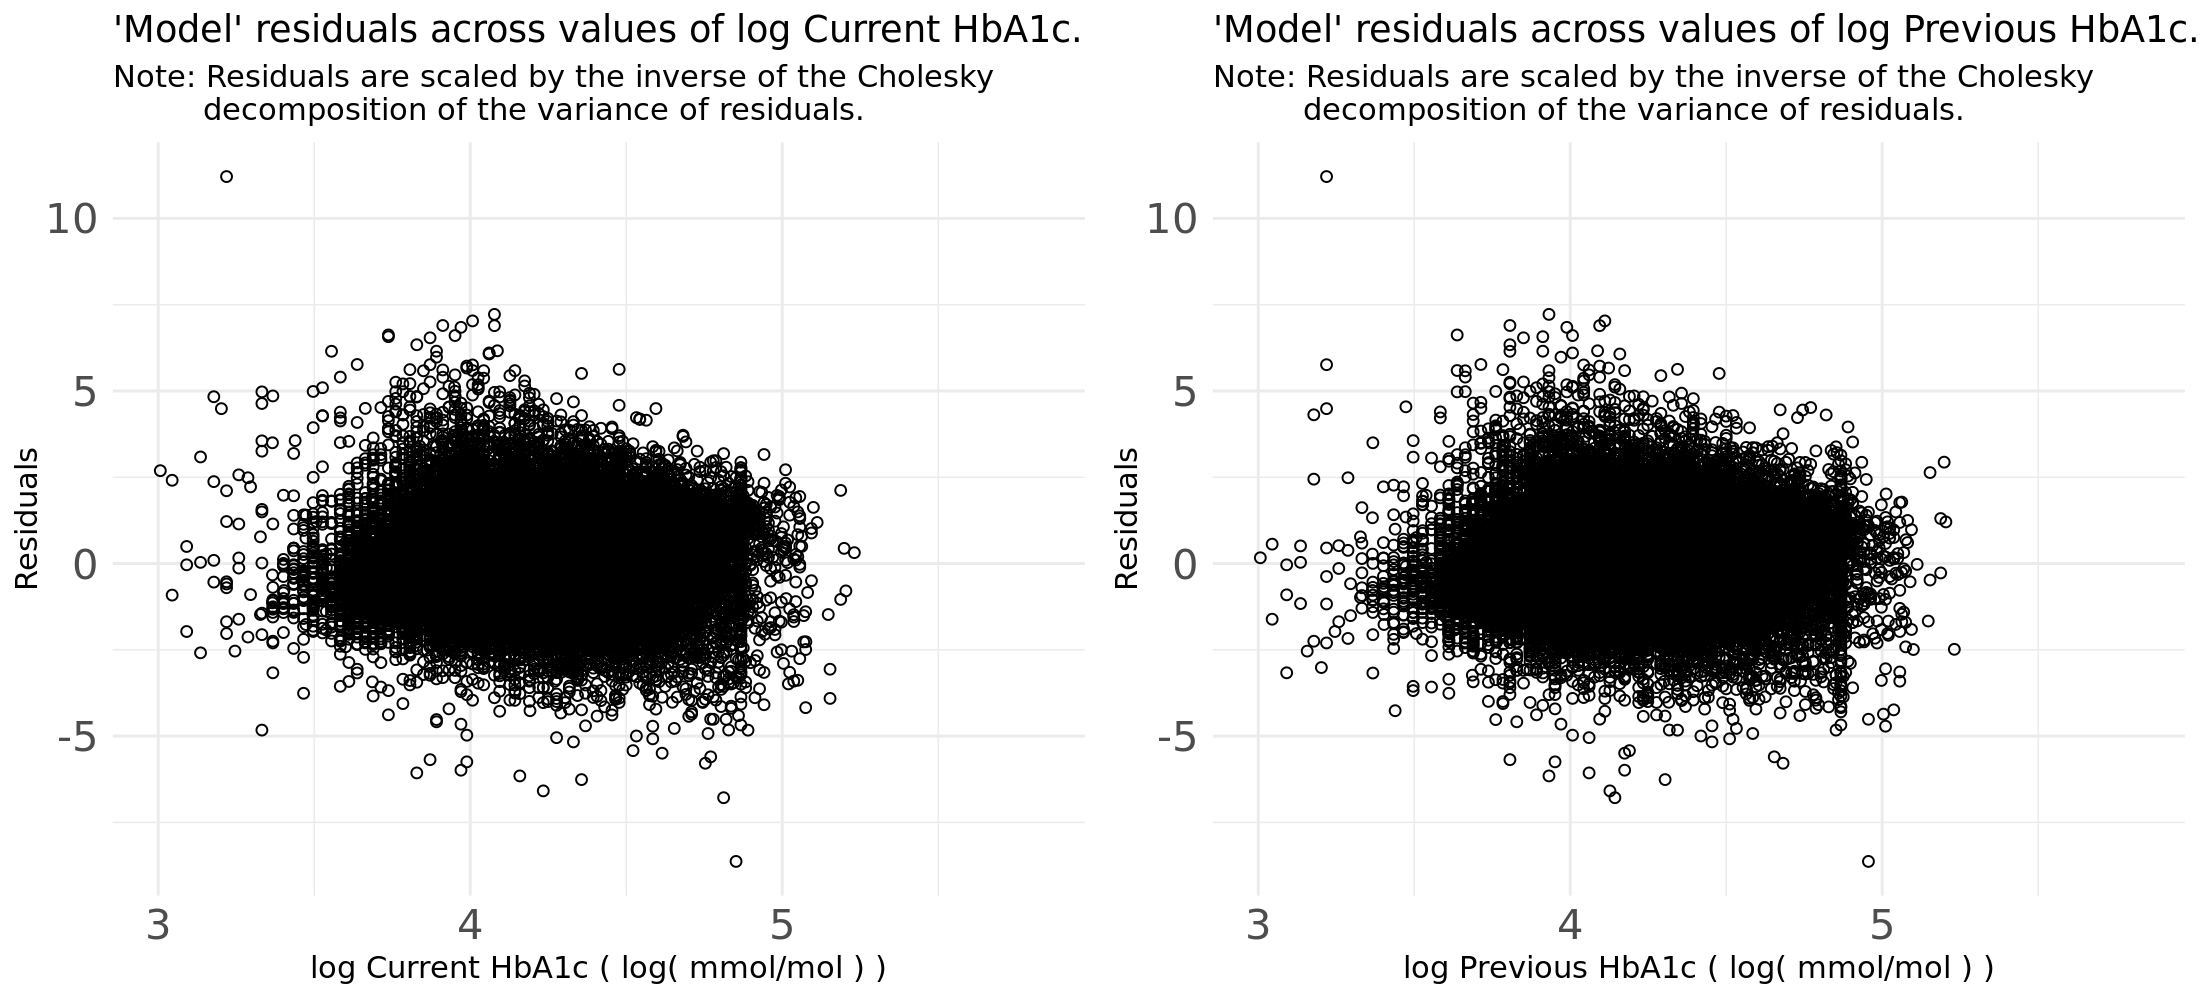

In [19]:
options( repr.plot.width = 11, repr.plot.height = 5, repr.plot.res = 200 )

plot_residuals_Current_HbA1c <-
    plot_df %>%
    ggplot() +
    geom_point(
        aes( x = Current_HbA1c_log, y = chol_diffs )
        ,shape = 21
    ) +
    labs(
        title = "'Model' residuals across values of log Current HbA1c."
        ,subtitle = "Note: Residuals are scaled by the inverse of the Cholesky\n         decomposition of the variance of residuals."
        ,x = "log Current HbA1c ( log( mmol/mol ) )"
        ,y = "Residuals"
    ) +
    xlim( max( log( test_value_cutoff_lower ), log( test_value_cutoff_lower )*-1.1 ), log( test_value_cutoff_upper )*1.1 ) +
    theme_minimal() +
    theme(
        ,legend.title = element_blank()
        ,legend.position = 'none'
        ,axis.text = element_text( size = 15 )
    )

plot_residuals_Previous_HbA1c <-
    plot_df %>%
    ggplot() +
    geom_point(
        aes( x = Previous_HbA1c_log, y = chol_diffs )
        ,shape = 21
    ) +
    labs(
        title = "'Model' residuals across values of log Previous HbA1c."
        ,subtitle = "Note: Residuals are scaled by the inverse of the Cholesky\n         decomposition of the variance of residuals."
        ,x = "log Previous HbA1c ( log( mmol/mol ) )"
        ,y = "Residuals"
    ) +
    xlim( max( log( test_value_cutoff_lower ), log( test_value_cutoff_lower )*-1.1 ), log( test_value_cutoff_upper )*1.1 ) +
    theme_minimal() +
    theme(
        ,legend.title = element_blank()
        ,legend.position = 'none'
        ,axis.text = element_text( size = 15 )
    )

cowplot::plot_grid(
    plot_residuals_Current_HbA1c
    ,plot_residuals_Previous_HbA1c
    ,nrow = 1
)

The pattern of the residuals closely mirrors the main residual plot. The saturation line is now vertical rather tan sloping down and right. 

## Calibration plot.
Important information can also be garnered from the intercept and slope of the fitted line. The intercept and slope of the fitted calibration model should be 0 and 1, respectively. In the calibration plot below, the linear line of best fit (blue) will match the line of identity (black) for a perfectly calibrated model. ( Note: The model of the linear line of best fit is a GLMM that used a random intercept for person_id to account for the dependency between patients' repeated observations.)

Computing profile confidence intervals ...



2.5 %      97.5 %  
(Intercept) 42.1843631 41.8378011 42.53005
obs          0.3383997  0.3337192  0.34312

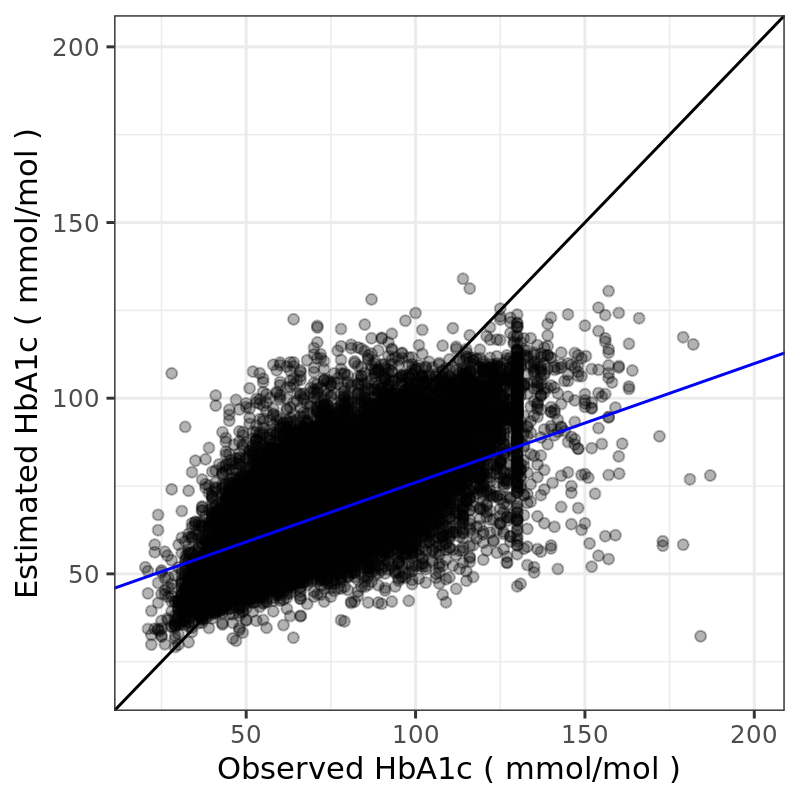

In [20]:
options( repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 200 )
my_transparency <- 0.3 

calibration_mod <-
    plot_df %>%
    dplyr::mutate( pred = exp( pred ), obs = exp( obs) ) %>%
    tidyr::drop_na() %>%
    lme4::lmer(
            pred ~ obs + ( 1 | person_id  )
            ,data = .
        )
fit_coeffs <- 
    calibration_mod %>%
    summary() %>%
    coefficients()

plot_df %>%
ggplot( aes( x = obs %>% exp(), y = pred %>% exp() ) ) +
geom_abline( intercept = 0, slope = 1 ) +
geom_point( alpha = my_transparency ) +
geom_abline( intercept = fit_coeffs[1,1], slope = fit_coeffs[2,1], colour = "blue" ) +
xlim( max( test_value_cutoff_lower, test_value_cutoff_lower*-1.1 ), test_value_cutoff_upper ) +
ylim( max( test_value_cutoff_lower, test_value_cutoff_lower*-1.1 ), test_value_cutoff_upper ) +
labs(
    x = "Observed HbA1c ( mmol/mol )"
    ,y = "Estimated HbA1c ( mmol/mol )"
) +
theme_bw()

cbind(
    fit_coeffs[ ,1 ]
    ,confint( calibration_mod )[ c( '(Intercept)', 'obs'), ]
)

Unfortunately, the fitted intercept and slope tell us that, on average:
1. we under-estimate by about a third (see 'obs' value)...
2. ...but then, over-estimates by an offset of approximately 42 mmol/mol (see 'intercept' value).

The calibration plot shows that a large range of HbA1c values can be estimated from the covariate / 'predictor' values corresponding to an observed HbA1c. For example, an observed value of 50 mmol/mol corresponds to 'predicted' values between 25 and 110 mmol/mol. Although our GEE can estimate the population mean HbA1c precisely, it is likely to be a poor at estimating any individual's HbA1c because the spread of HbA1c is so great.



__As it stands, the GEE is not a generalisably accurate prediction model because HbA1c values show such large variance.__ This is despite the fact that the estimated means that are used as the predictions are very good estimates of the true population means. This is a case where the mean is not a good representation of the distribution, even if it is the least biased representation possible.

# Estimations / 'Predictions' from the GEE.
In the plot below, I show the 'predicted' subsequent HbA1c values for a range of lagged HbA1c values. The values of lagged HbA1c are the thresholds for the Red-Amber-Yellow-Green rating I've used during the RESHAPE project, but any values for HbA1c can be entered:
- 48, 58, and 68 mmol/mol: below 48 mmol/mol puts a record in Green;
- between 48-58 mmol/mol puts a record in Yellow;
- between 58-68 mmol/mol puts a record in Amber; above 68 mmol/mol puts a record in Red.

These 'predicted' HbA1c values are stratified by the history of HMA state. The lowest (but most uncertain) 'predicted' HbA1c value is associated with a patient record showing an Adjust-Adjust history of HMA states with two successive previous HbA1c test results in the Green. Conversely, the highest 'predicted' HbA1c value is associated with a patient record showing a Hold-Hold history of HMA states with two successive previous HbA1c test results in the Red.

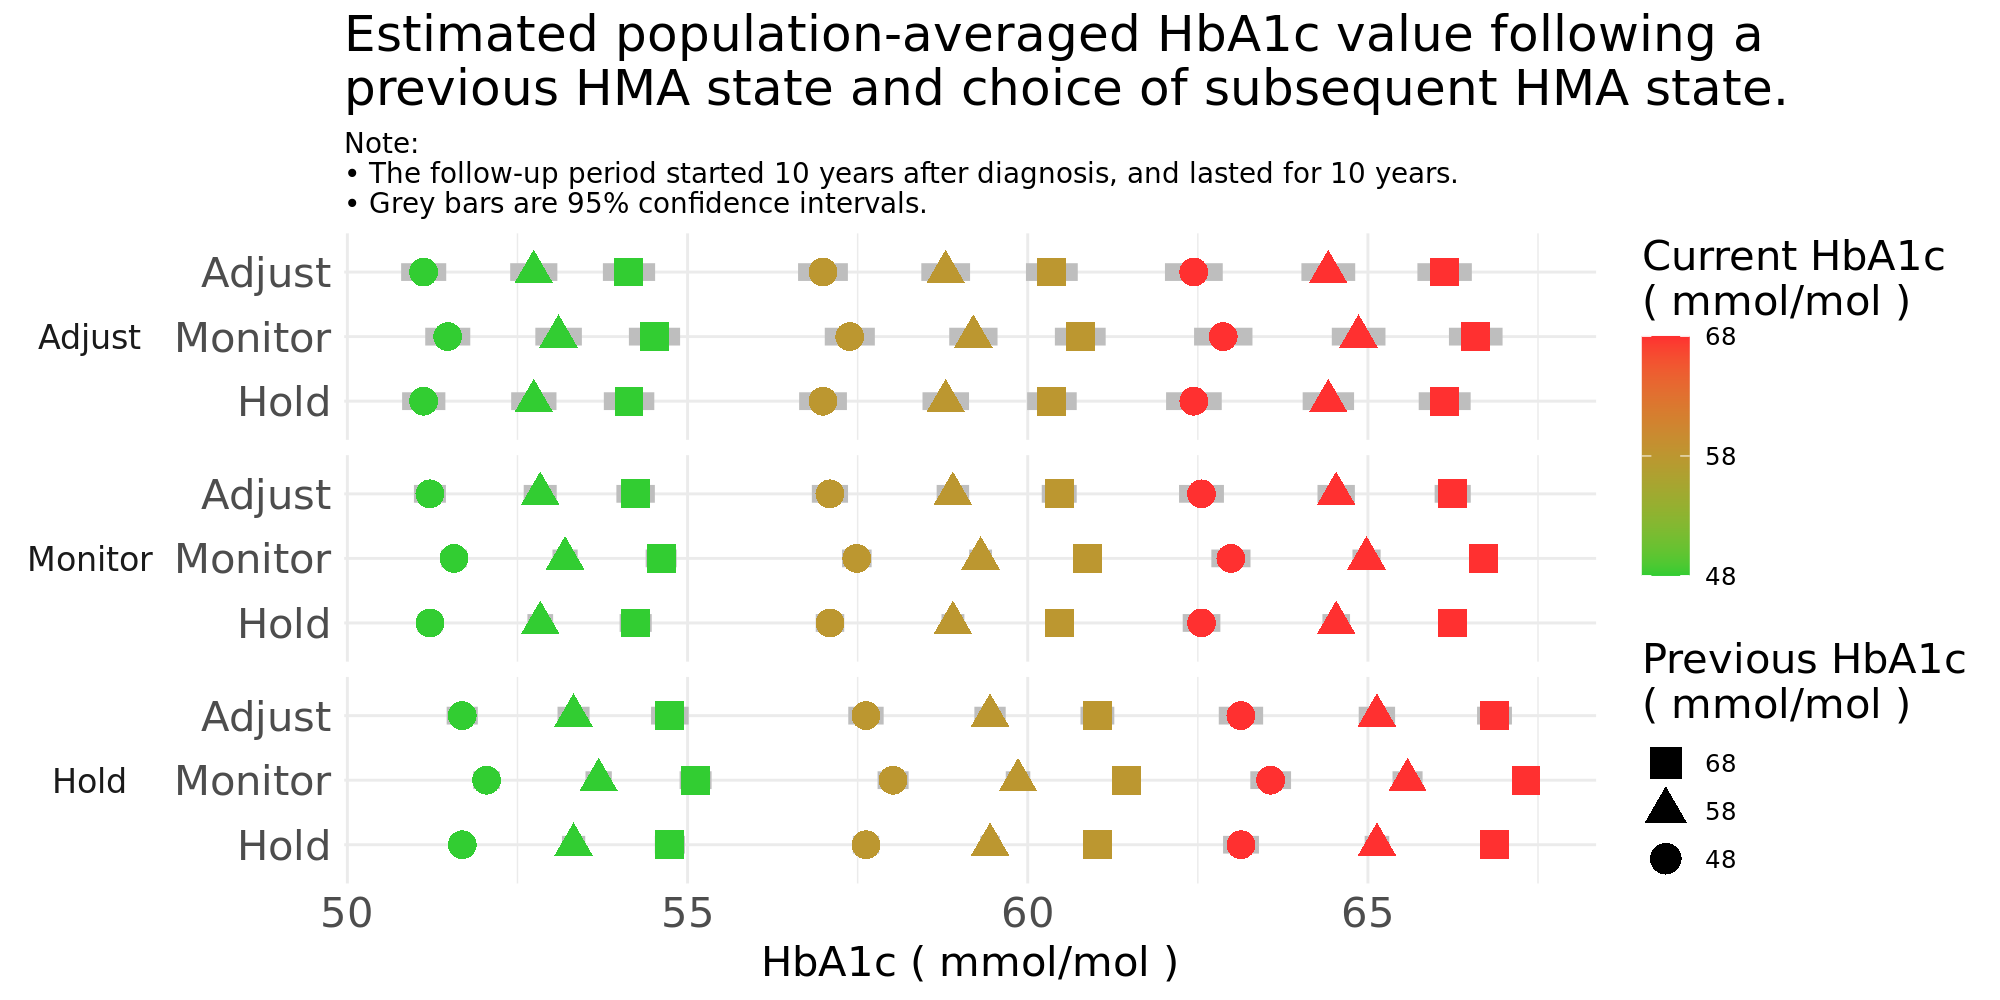

In [21]:
options( repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200 )

HbA1c_values_to_plot <- c( 48, 58, 68 ) %>% log()

# Get the standard errors of the estimation.
estimated_means <-
    emmeans::emmeans(
        GEE_twoHbA1c_twoHMA_AgeMultiMorb
        ,~ Current_HbA1c_log + Previous_HbA1c_log + Next_HMA + Current_HMA
        ,at = list( Current_HbA1c_log = HbA1c_values_to_plot, Previous_HbA1c_log = HbA1c_values_to_plot )
    ) %>%
    as.data.frame() %>%
    dplyr::mutate(
        emmean = exp( emmean )
        ,asymp.LCL = exp( asymp.LCL )
        ,asymp.UCL = exp( asymp.UCL )
    )


# Plot the estimated means.
plot_GEE_estimate_means <-
    estimated_means %>%
    ggplot(
        aes(
            x = Current_HMA
            ,y = emmean
            ,group = Previous_HbA1c_log %>% exp() %>% round()
        )
    ) +
    geom_linerange(
        aes(
            ymin = asymp.LCL
            ,ymax = asymp.UCL
        )
        ,colour = "grey"
        ,linewidth = 3
    ) +
    geom_point(
        aes(
            shape = factor( Previous_HbA1c_log %>% exp() %>% round() )
            ,colour = Current_HbA1c_log %>% exp() %>% round()
            ,size = 5
        )
    ) +
    labs(
        title = "Estimated population-averaged HbA1c value following a\nprevious HMA state and choice of subsequent HMA state."
        ,subtitle = paste0(
            "Note: \n"
            ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis, and lasted for ", followup_duration_in_years," years.\n")
            ,"\u2022 Grey bars are 95% confidence intervals."
            )
        ,y = "HbA1c ( mmol/mol )"
        ,shape = "Previous HbA1c\n( mmol/mol )"
        ,colour = "Current HbA1c\n( mmol/mol )"
    ) +
    facet_grid( rows = vars( fct_rev( Next_HMA ) ), switch = "both", scales = "free_x", space = "free_x") +
    coord_flip() +
    guides( shape = guide_legend( reverse = TRUE, override.aes = list( size = 5 ) ), size = 'none' ) +
    scale_colour_gradient(
        breaks = HbA1c_values_to_plot %>% exp() %>% round()
        ,labels = HbA1c_values_to_plot %>% exp() %>% round()
        ,low = "limegreen"
        ,high = "firebrick1"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 15 )
        ,strip.placement = "outside"
        ,strip.text.y.left = element_text( size = 12, angle = 0 )
        ,axis.title.y = element_blank()
        ,plot.subtitle = element_text( size = 10 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,axis.text = element_text( size = 15 )
    )
    

plot_GEE_estimate_means


## Manifestation of poor calibration.
The 'predicted' values that follow a history of Green HbA1c values (green markers) are all higher than the Green threshold (HbA1c = 48 mmol/mol). This is despite the early plots of observed HbA1c versus lagged HbA1c suggesting that HbA1c values lead to lower subsequent HbA1c, on average. This is inkeeping with the calibration plot that showed the 'model' over-estimating lower values. Also, the 'predicted' values that follow a history of Red HbA1c values (red markers) are all lower than the Red threshold (HbA1c = 70 mmol/mol). This is inkeeping with the calibration plot that showed the 'model' under-estimating higher values.

# Results.

The initial exploration of observed data suggest that:
1. HbA1c is log-Normally distributed;
2. the distribution of HbA1c is mirrored in each strata of HMA-state sequence pair;
3. the data include a portion of data with a saturation threshold at 130 mmol/mol
4. subsequent HbA1c values are lower, on average (as indicated by shallow linear lines of best fit).
5. HbA1c values cluster periodically along their observed range;
6. age and multimorbidity status offer almost no information about HbA1c, in isolation; _and_
7. HbA1c values demonstrate moderate first-order autocorrelation, and weak but statistically-significant (at a level of 0.05) autocorrelation up to almost the 30th order. This autocorrelation changes from positive to negative at the fourth order.


The evaluation of the model fit suggests that:
1. the GLMM with the best fit was specified with second-order lags for HbA1c and HMA, and with a covariate for age and multimorbidity status;
2. the residuals from the GEE are well behaved; _and_
3. the 'model' is not an accurate prediction model, generally.


A summary of the 'predictions' suggests that:
1. the 'predictions' are barely distinguished by a short history of HMA state;
2. the 'predictions' are  distinguished by a short history of HbA1c values (but patient records with a recent history of the Adjust HMA state will have an uncertain 'prediction'); _and_
3. 'predictions' are over-estimates of lower values and under-estimates of higher values.


# Discussion
It is imporant to understand the context of these data, when interpreting the results:
1. This cohort of healthcare records are for those patients whose diagnosis was before 2000.
2. This cohort of healthcare records are those 10 years after the patient's diagnosis.
3. The proportion of HbA1c values in these records are predominantly Red (>78 mmol/mol) or Yellow (>48 mmol/mol), followed by Amber (>58 mmol/mol), and relatively few Green ($\le$48 mmol/mol).
4. The method I've used considers all successive 3-event sequences within and across patients - i.e. 1 = HMA state, 2 = HMA state, 3 = HbA1c value - so patients with long sequences will contribute more to the calculated means than those with short sequences because they contain more 3-event subsequences.
5. The patients with longer sequences are more stable in their HMA states so the scenarios with repeated states (e.g. Hold-Hold or Monitor-Monitor) are more common and, thus, weighted more in the calculated means.
6. The analysis does not explicitly account for prior HbA1c values so we cannot suppose to what extent the HMA states are responses to changes (or stability) of HbA1c values.
7. The count of patients with records of an Adjust state has a half life of one inter-test interval. This means that there are almost no instances of the Adjust state after the fifth test event.
8. I have limited the patient records to those with HbA1c values within a range of 40 to 100. (Note, a calibration plot of a model informed by data with a lower bound of zero shows an angled rugby-ball shape that one might expected from predictions that correspond well to observed values and which show lesser variance in the extremes.)

## The variance needs to be handled.
The evaluation of the 'model' fit suggested that the HbA1c values are inherently highly varied, and 'predictions' are equally varied across the full range of true, observed values. Crucially, one must recognise that the GEE (and GLMMs for that matter) are modelling the mean of the variate. The GEE approach that I have used is providing precise population-averaged estimates of the mean HbA1c, given the covariates. Unfortunately, the estimates do not account for the inherently high variance.

A Generalised Least Squares (GLS) regression model would permit us to suggest covariates and a structure for modelling the variance, as well as the mean, but it returns us to the problem of requiring the `person_id` value for a prediction to have been part of the model-fitting process. There might be some hope in [GEEEs](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9559327/), which is a new find, and which, thankfully, has an [R package](https://github.com/amadoudiogobarry/expectgee).

## Monitor-state means are indistinguishable from Hold-state 'predictions'.
Monitor-state means are indistinguishable from Hold-state means, whether means are grouped by the twice-lagged state or the once-lagged state. Given that the Monitor state is defined by more frequent testing, one might conclude that the additional burden of this testing does not confer improvement in subsequent HbA1c and is unnecessary. However, the greater frequency of testing might have provided peace of mind, which is an unmeasured part of the sociobiology of healthcare.

## An Adjust state is associated with a lower 'predicted' HbA1c.
An Adjust state is associated with a lower mean subsequent HbA1c. My hypothesised direct acyclic graph implies that twice-lagged HbA1c informs the twice-lagged HMA state, and similarly for the once-lagged values. The plot shows that when twice-lagged HbA1c was high, those patients with a record of entering an Adjust state had a lower 'predicted' HbA1c. This is evidenced by the lower 'predicted' HbA1c values for the largest dots in the top set of three HMA states, compared with the largest dots in the other sets of three HMA states. Similarly, given any twice-lagged HMA state, those patients with a record of entering an Adjust state after their once-lagged HbA1c was high had a lower 'predicted' HbA1c. This is evidenced by the lower 'predicted' HbA1c values for the lightest-blue dots associated with an Adjust state in the each set of three HMA states. Once might conclude that adjustments were effective but one must be wary of regression to the mean.

# Confidence intervals are wide for the Adjust-state means, specifically.
A simple plot of the estimated means and their 95% confidence intervals shows that all of the confidence intervals overlap. This implies that the true value of the mean could be the same (around 67 mmol/mol) for all scenarios. However, the substantially-wider intervals found in any scenario that included the 'Adjust' state is likely due to the relatively-very small number of observations of the 'Adjust' state. With so few observations of scenarios involving the 'Adjust' state, we don't have much confidence that those sample observations are representative, so our interval must be set wide to acknowledge the uncertainty in our inference about the true population mean. Were the confidence intervals for scenarios involving the 'Adjust' state similar to those for the other scenarios, we could infer markedly worse mean HbA1c for scenarios with an Adjust value in the once-lagged state.

In [22]:
Sys.time() - t1

Time difference of 5.661269 mins